                                                                                                                 
# MOA1 - ML project

## Drug sensitivity prediction & precision oncology

### Drug name: Nilotinib
### Cancer type: Leukemia

#### Authors: Aapo Saavalainen & Tiina Tuononen
#### Date: 17.12.2022

## Table of contents
1.	[Introduction](#section_1)<br>
2.	[Environment and data preparation](#section_2)<br>
    2.1  [Importing necessary modules](#section_2.1)<br>
    2.2  [Loading the data](#section_2.2)<br>
    2.3  [Inspecting the contents of the datasets](#section_2.3)<br>
    2.4  [Visualizing gene expression profile of cancer cell lines (CCLE and GDSC)](#section_2.4)<br>
    2.5  [Transforming the targets into a categorical variable](#section_2.5)<br>
    2.6  [Splitting the CCLE dataset into train and test sets](#section_2.6)<br>
    2.7  [Checking/imputing missing values](#section_2.7)<br>
    2.8  [Scaling the data](#section_2.8)<br>
3.	[Exploratory analysis](#section_3) <br>
    3.1	[PCA of CCLE and GDSC mRNA data](#section_3.1) <br>
    3.2	[Collinearity of the features in CCLE mRNA training data](#section_3.2) <br>
4.  [Model training, validation and testing](#section_4)<br> 
    4.1	[Training classifiers on CCLE mRNA data and testing their accuracy ](#section_4.1) <br>
    4.2	[Analysis of all classifiers](#section_4.2) <br>
    4.3	[Training regressors on CCLE mRNA data and testing their performance](#section_4.3) <br>
    4.4	[Analysis of all regressors ](#section_4.4) <br>
5.	[Selecting biomarkers of drug sensitivity](#section_5) <br>
    5.1	[Compare feature importance using feature weights](#section_5.1) <br>
    5.2 [Feature importance in literature](#section_5.2) <br>
6.	[Clustering mRNA profiles of cancer patients](#section_6) <br>
    6.1	[Compare gene expression trends between patien subgroups and sensitive/resistant cancer cell lines](#section_6.1) <br>
7.  [Discussion](#section_6) <br>
8.	[References](#section_7) <br>

## 1. Introduction <a id="section_1"></a>


Cancer cell lines carry similar genetic aberrations as the tumor from which they were derived, recapitulating many of the features of the original tumor. Use of cancer cell lines enables relatively inexpensive high-throughput screening of drugs and therefore, cancer cell lines are widely used in pharmacogenomics studies, which are aiming  to link genomic features to drug response. These identified genomic features using cancer cell lines can be used as predictive signatures of patient therapy response and outcome, allowing more precise and personalized treatments (Goodspeed et al. 2016). 

This project focuses on leukemia and responses to Nilotinib, which is a second-generation tyrosine kinase inhibitor used for frontline treatment of chronic myeloid leukemia (Kantarjian et al. 2021). The main objectives of this project are to 1) identify biomarkers (genes) of Nilotinib response from cancer cell line data using supervised learning and 2) classify leukemia patients into molecular subgroups based on identified biomarkers using unsupervised learning. Finding molecular subgroups  from patient data based on found biomarkers could be used to predict patients drug response in a personalized manner. 

To date, several large-scale pharmacogenomics datasets exist and are publicly available as a resource to the biomedical research community. In this project we use the Cancer Cell Line Encyclopedia (CCLE) and Genomics of Drug Sensitivity in Cancer (GDSC) datasets to find biomarkers for Nilotinib sensitivity, and leukemia patient data from The Cancer Genome Atlas (TCGA) - project. 


## 2. Environment and data preparation <a id="section_2"></a>

### 2.1. Importing necessary modules <a id="section_2.1"></a>

Pandas and numpy are the standard dataframe and algebra modules in Python. Matplotlib and seaborn are useful tools for visualization of the results. 

In [2]:
# Importing the necessary modules. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2.2 Loading the data <a id="section_2.2"></a>

As earlier described, in this project we use publicly available pharmacogenomics datasets CCLE and GDSG. CCLE was a collaboration project between the Broad Institute and the Novartis Institutes for Biomedical research,  that offers  a large-scale genomic dataset for 947 human cancer cell lines, including  gene expression, chromosomal copy number and massive parallel sequencing data coupled with pharmacological profiles for 24 anticancer drugs (Barretina et al. 2012). This data will be used to identify biomarkers for drug sensitivity. GDSC was a collaboration between The Cancer Genome Projest at the wellcome Sanger Institute (UK) and the Center for Molecular Therapeutics, Massachisetts General Hospital Cancer Center (USA). This project provides similar data as CCLE, describing response to 138 anticancer drugs across almost 700 cancer cell lines, which allows us to use it as an external test set in our project (Yang et al. 2013).  In our project we use only subsets of these large datasets, that contain only leukemic cell lines that were tested for Nilotinib sensitivity. 

In [3]:
#importing the data and setting the first column (cell lines) as index. 

pd.set_option('display.max_columns', 20)
ccle=pd.read_csv("ccle_nilotinib_mrna.csv", sep=",", index_col="Unnamed: 0")
gdsc=pd.read_csv("test_nilotinib_mrna.csv", sep=",", index_col="Unnamed: 0")

### 2.3 Inspecting the contents of the datasets <a id="section_2.3"></a>

Let's take a quick look at the data frames. We see that as index, we have cell lines and that each column represents a gene and its expression values. The last column is target, which contain Area under dose-response curve (AUC) values for the Nilotinib. AUC corresponds drug sensitivity, when higher values indicate stronger cell sensitivity to certain drug. 

In [ ]:
ccle.head()

ENSG00000000938  ENSG00000000971  ENSG00000001626  ENSG00000004864  \
22Rv1         4.278374         4.166978         3.620812         9.466285   
5637          4.448141         5.379507         3.637369         9.396675   
639V          4.499695         7.465790         3.669174         8.008268   
697           4.547717         3.998887         3.848459         4.081237   
769-P         4.802576         4.913383         3.794203         9.509946   

       ENSG00000004939  ENSG00000005022  ENSG00000005379  ENSG00000006071  \
22Rv1         4.196876        13.639696         6.446682         4.343322   
5637          4.282229        13.551635         4.753128         4.787415   
639V          4.327116        13.780897         4.765087         4.745644   
697           4.226873        13.402915         5.617050         4.870626   
769-P         4.368425        13.115675         4.677229         4.879073   

       ENSG00000009790  ENSG00000010017  ...  ENSG00000108406  \
22Rv1         3.720707         9.021234  ...        10.306653   
5637          3.898829         7.787249  ...        10.106010   
639V          3.795107         9.672360  ...         9.530962   
697           5.016915         9.841673  ...         9.760033   
769-P         3.850514         8.502760  ...         9.478090   

       ENSG00000176407  ENSG00000179295  ENSG00000167182  ENSG00000135070  \
22Rv1         9.348885         6.745546         8.250750        11.205515   
5637          7.284097         5.969247         8.895973              NaN   
639V          7.038533         6.745090         7.468865              NaN   
697           7.340465         7.044699         7.974182        10.221340   
769-P         8.452726         6.858774         8.002279        10.933266   

       ENSG00000117505  ENSG00000157106  ENSG00000107949  ENSG00000129152  \
22Rv1         7.404605         8.125749         9.311888         4.538080   
5637          7.668579         7.436397         9.076644         4.974953   
639V          8.337187         8.255489              NaN         4.511653   
697           7.874297         8.764067         8.286442         4.599851   
769-P         8.029914         8.716885         9.798531         4.784975   

             target  
22Rv1  3.915114e-14  
5637   2.598877e-02  
639V   2.017529e-02  
697    1.757480e-01  
769-P  5.698866e-02  

[5 rows x 396 columns]

In [ ]:
gdsc.head()

ENSG00000000938  ENSG00000000971  ENSG00000001626  ENSG00000004864  \
22Rv1            4.410554         4.725042         4.702611         7.592869   
23132/87         4.329337         4.789347         4.285765         7.538182   
5637             4.396651         5.819378         4.170312         7.950318   
639V             4.176680         8.862957         4.414732         5.666471   
647V             4.275789         5.219037         4.276247         8.385942   

          ENSG00000004939  ENSG00000005022  ENSG00000005379  ENSG00000006071  \
22Rv1            4.466390        11.948889         4.985479         4.463956   
23132/87         4.622279        12.279835         4.573834         4.218829   
5637             4.442109        12.032569         4.617223         4.416153   
639V             4.567857        12.621478         5.034873         4.667162   
647V             4.450808        12.526807         4.510625         4.487778   

          ENSG00000009790  ENSG00000010017  ...  ENSG00000108406  \
22Rv1            4.620355         7.318318  ...         7.930663   
23132/87         4.313259         7.252433  ...         7.617128   
5637             4.531214         7.706012  ...         9.451022   
639V             4.119721         8.659570  ...         7.566072   
647V             4.295957         9.131334  ...         9.298724   

          ENSG00000176407  ENSG00000179295  ENSG00000167182  ENSG00000135070  \
22Rv1           10.929644         7.733476         4.879350         9.309219   
23132/87        10.494962         8.472246         5.343685         9.596453   
5637            11.301454         7.725129         5.980694        10.117630   
639V            10.668208         8.540190         5.234855         8.703989   
647V             9.893142         8.397216         5.592758         9.095497   

          ENSG00000117505  ENSG00000157106  ENSG00000107949  ENSG00000129152  \
22Rv1            6.234567         5.403778         7.638494         4.967751   
23132/87         6.068082         5.186644         7.159431         5.279856   
5637             6.882690         5.806459         6.721741         5.086397   
639V             6.319940         6.110326         7.723440         4.786608   
647V             7.031066         6.281213         6.090876         4.838277   

            target  
22Rv1     0.059262  
23132/87  0.044378  
5637      0.038825  
639V      0.000000  
647V      0.000000  

[5 rows x 396 columns]

In [ ]:
ccle.describe()

ENSG00000000938  ENSG00000000971  ENSG00000001626  ENSG00000004864  \
count       406.000000       406.000000       406.000000       406.000000   
mean          4.924632         5.665702         3.835107         8.860077   
std           1.190849         2.090012         0.838858         1.007643   
min           3.866661         3.469390         3.448857         3.704140   
25%           4.444231         4.039355         3.601283         8.344458   
50%           4.601508         4.532799         3.654125         8.948947   
75%           4.801661         7.202326         3.742335         9.469215   
max          10.943947        12.036873        11.327298        11.201014   

       ENSG00000004939  ENSG00000005022  ENSG00000005379  ENSG00000006071  \
count       406.000000       406.000000       406.000000       406.000000   
mean          4.339697        13.311265         4.845611         4.608482   
std           0.293809         0.368792         0.776859         0.494353   
min           3.686007        11.942373         3.880936         3.453329   
25%           4.223080        13.114267         4.415077         4.357650   
50%           4.321608        13.357991         4.646823         4.543337   
75%           4.426993        13.572149         4.982886         4.725195   
max           9.261109        14.057212        10.184866         8.538346   

       ENSG00000009790  ENSG00000010017  ...  ENSG00000108406  \
count       406.000000       406.000000  ...       367.000000   
mean          4.219476         9.059941  ...         9.872102   
std           1.042443         0.617713  ...         0.651288   
min           3.469617         7.267152  ...         7.879818   
25%           3.746650         8.647272  ...         9.484296   
50%           3.829753         9.064167  ...         9.894185   
75%           3.935312         9.435198  ...        10.266430   
max           8.697576        11.167148  ...        12.239190   

       ENSG00000176407  ENSG00000179295  ENSG00000167182  ENSG00000135070  \
count       372.000000       369.000000       367.000000       366.000000   
mean          7.554829         6.519758         7.866583        10.585431   
std           0.411703         0.360497         0.471640         0.585002   
min           6.541857         4.917611         6.126256         8.868893   
25%           7.287700         6.298834         7.611330        10.223768   
50%           7.535247         6.508357         7.886608        10.601544   
75%           7.804012         6.743681         8.184048        10.957090   
max           9.348885         7.666266         9.030977        12.369748   

       ENSG00000117505  ENSG00000157106  ENSG00000107949  ENSG00000129152  \
count       367.000000       368.000000       364.000000       370.000000   
mean          7.880853         8.530733         9.267253         4.686647   
std           0.422264         0.498672         0.610561         0.468507   
min           6.426173         7.237753         7.366480         4.059815   
25%           7.588486         8.236961         8.814041         4.489085   
50%           7.862249         8.488999         9.308381         4.636620   
75%           8.126967         8.830375         9.712268         4.793539   
max          10.252776        10.030224        11.245671        11.883861   

           target  
count  406.000000  
mean     0.051362  
std      0.093808  
min      0.000000  
25%      0.012868  
50%      0.030571  
75%      0.059096  
max      0.904192  

[8 rows x 396 columns]

In [ ]:
gdsc.describe()

ENSG00000000938  ENSG00000000971  ENSG00000001626  ENSG00000004864  \
count       509.000000       509.000000       509.000000       509.000000   
mean          4.624540         5.739482         4.545373         7.335157   
std           1.103658         1.533845         0.476652         1.092938   
min           3.882403         4.013279         4.055264         4.257449   
25%           4.245674         4.746303         4.368860         6.665815   
50%           4.348870         5.014331         4.465623         7.369291   
75%           4.462372         6.368842         4.570850         8.000401   
max          11.202087        12.151067         9.250850        10.249570   

       ENSG00000004939  ENSG00000005022  ENSG00000005379  ENSG00000006071  \
count       509.000000       509.000000       509.000000       509.000000   
mean          4.533061        12.170872         4.921445         4.642583   
std           0.197979         0.514504         0.887702         0.677515   
min           4.146409         9.462783         4.111084         4.021039   
25%           4.400503        11.859854         4.474165         4.375603   
50%           4.503558        12.234270         4.624978         4.494633   
75%           4.641384        12.549621         4.945072         4.651432   
max           5.433134        13.562838        10.758982        11.261061   

       ENSG00000009790  ENSG00000010017  ...  ENSG00000108406  \
count       509.000000       509.000000  ...       509.000000   
mean          4.760044         7.758666  ...         8.702001   
std           0.931418         0.704357  ...         0.806856   
min           3.981496         6.302039  ...         4.407539   
25%           4.317544         7.214565  ...         8.173557   
50%           4.410289         7.641626  ...         8.732572   
75%           4.581726         8.259082  ...         9.191892   
max           9.019453         9.991323  ...        11.056374   

       ENSG00000176407  ENSG00000179295  ENSG00000167182  ENSG00000135070  \
count       509.000000       509.000000       509.000000       509.000000   
mean         10.617170         8.123705         5.353735         9.297059   
std           0.515379         0.395088         0.482464         0.681697   
min           8.680271         6.916066         4.065169         6.784110   
25%          10.240217         7.860432         5.030505         8.896795   
50%          10.598585         8.105058         5.339465         9.291414   
75%          10.953007         8.387846         5.624840         9.754074   
max          12.167310         9.424042         7.384757        11.054559   

       ENSG00000117505  ENSG00000157106  ENSG00000107949  ENSG00000129152  \
count       509.000000       509.000000       509.000000       509.000000   
mean          6.421926         5.989380         7.181365         5.124804   
std           0.580087         0.653383         0.800086         0.490417   
min           5.103743         4.099519         5.040184         4.436598   
25%           6.068082         5.605331         6.650422         4.926627   
50%           6.353455         5.926426         7.197379         5.070473   
75%           6.744708         6.324724         7.731896         5.211539   
max           8.467308         8.533625        10.042079        11.797191   

           target  
count  509.000000  
mean     0.047655  
std      0.094761  
min      0.000000  
25%      0.001769  
50%      0.024552  
75%      0.063113  
max      0.917457  

[8 rows x 396 columns]

In [ ]:
print("ccle:", ccle.shape)
print("gdsc:", gdsc.shape)

ccle: (406, 396)
gdsc: (509, 396)


The CCLE and GDSC datasets contain the same number of columns (genes) and different amount of samples (cell lines), which is expected, since GDSC dataset includes more studied cell lines than CCLE. 

### 2.4 Visualizing gene expression profile of cancer cell lines (CCLE and GDSC) <a id="section_2.4"></a>



In this part, we'll explore how the data is distributed in both datasets. As gene expression and target values are presented  in separate columns. 

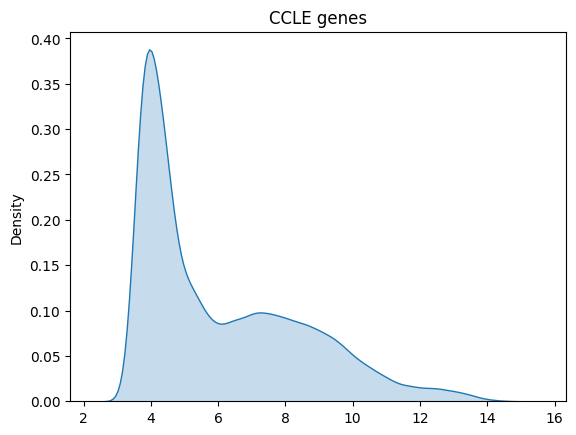

In [ ]:
#visualize the density of the whole ccle dataset

flatten_df = ccle.iloc[:,:-1].to_numpy().flatten()

#density plot from whole data
import seaborn as sb 


sb.kdeplot(flatten_df, fill = True)

plt.title("CCLE genes") ;


CCLE gene expression data is almost normally distributed, however a bit skewed to the right. From this plot we can see that the expression of most of the genes is relatively low. 

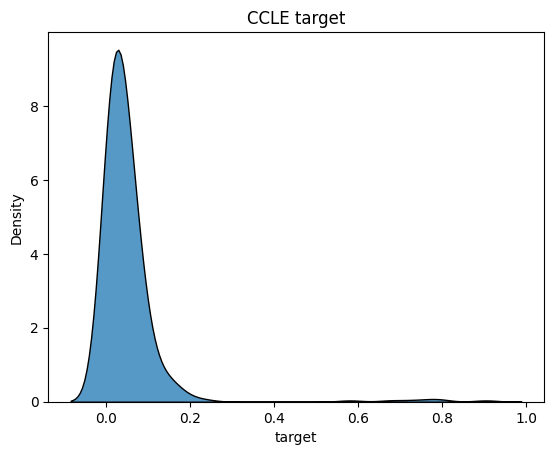

In [ ]:
#density plot of target variable of ccle data

sns.kdeplot(data=ccle['target'], multiple="stack")

plt.title("CCLE target") ;

Target variable (AUC) seems to be normally distributed, but we can detect that around 0.6-0.8 there is a little hump, which indicates that only small population of the studied cells have this high AUC. 

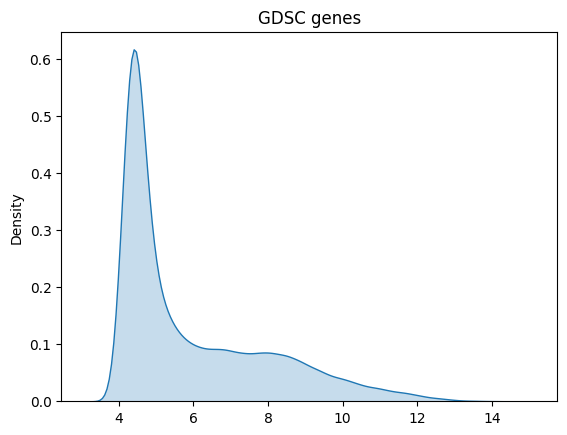

In [ ]:
#density plot from GDSC test data

flatten_df2 = gdsc.iloc[:,:-2].to_numpy().flatten()

sns.kdeplot(flatten_df2, fill = True)

plt.title("GDSC genes") ;

GDSC gene expression data follows similar distribution as CCLE, mostly normally distributed, but is a bit skewed to the right. Majority of the genes are lowly expressed. 

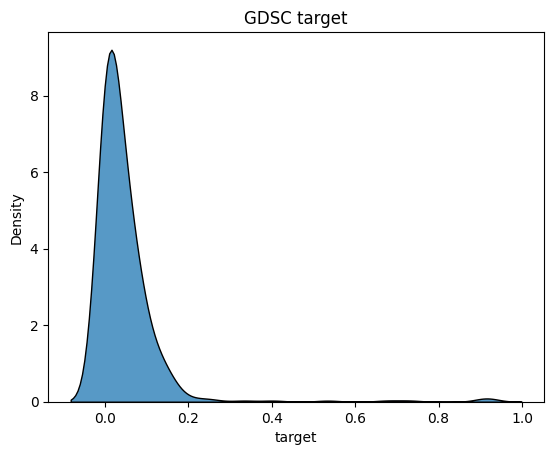

In [ ]:
#density plot of target variable (CDSC test set)

sns.kdeplot(data=gdsc['target'], multiple="stack")

plt.title("GDSC target") ;

Shape of the distribution of GDSC target is comparable to CCLE target, similar humps around 0.6-1 can be observed. 

### 2.5 Transforming the targets into a categorical variable <a id="section_2.5"></a>

AUC values for cell lines are provided by both of the datasets, and can be used as a target variable to evaluate the cell line responsiveness to Nilotinib.  

In this part of the project, we are interested in classifying cancer cell lines to have high or low sensitivity to the Nilotinib anti-cancer drug. As the target values is continuous, we'll have to transform them into discrete values. 0 represents cell lines with low sensitivity, and 1 sensitive ones. We'll have to look how the target column is distributed to see, if a clear threshold value exists.  

In [ ]:
#separate the genes and the target columns. 
X=ccle.iloc[:,:-1]
y=ccle['target']


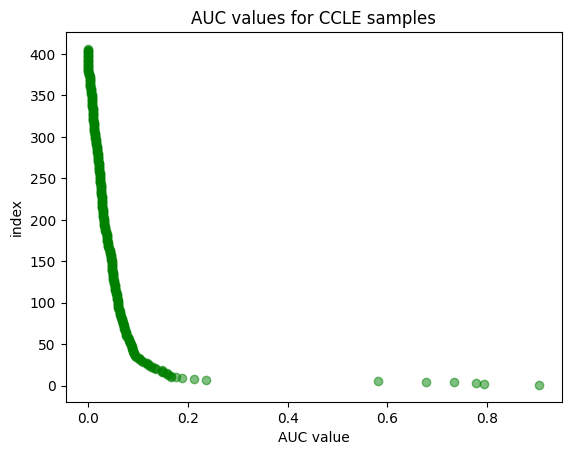

In [ ]:
#sorting target values to descending order for plottin
y_sorted=ccle['target']
y_sorted=y.sort_values(ascending=False)

#plotting
a=y_sorted
b=list(range(1,407))

plt.scatter(a, b, c="g", alpha=0.5) ;
plt.ylabel('index')
plt.xlabel("AUC value") ;

plt.title("AUC values for CCLE samples") ;


We can see from the AUC values, that there is a clear notch in the curve around the value 0,1. We shall use this as dividing point for sensitive and resistant cell lines. 

Next we'll discretize the values based on the selected threshold. 

In [4]:
#function, which can devide the data into two classes based on column.
def categorise(row):  
    if row['target'] <= 0.1 :
        return '0'
    elif row['target'] >0.1:
        return '1'
    

In [5]:
#Applying the function. This will create a new column to both dataframes, which will turn the continuos 
#AUC-values into binary, two class column. 
ccle['target_discrete'] = ccle.apply(lambda row: categorise(row), axis=1)
gdsc['target_discrete'] = gdsc.apply(lambda row: categorise(row), axis=1)


In [ ]:
#check how the data is distributed. 
all = ccle.shape[0]
categories = ccle['target_discrete'].value_counts()
print(categories)


0    373
1     33
Name: target_discrete, dtype: int64


It seems that classes are not balanced in CCLE dataset by using threshold 0.1, since only 33 samples are categorized as 1 (=sensitive).  However, this will most likely not be a problem, assuming that the two classes are distinguishable from each others.  Moreover, number of measured data points per sample is relatively high, so the overall amount of the data is still satisfying. Unbalanced class distribution can be taken into account in cross-validation by using stratified cross-validation.

In [ ]:
all = gdsc.shape[0]
categories = gdsc['target_discrete'].value_counts()
print(categories)


0    450
1     59
Name: target_discrete, dtype: int64


Similar class distribution using 0.1 threshold is observed in CDSC dataset, as expected. 

### 2.6 Splitting the CCLE dataset into train and test sets <a id="section_2.6"></a>

Splitting of the data into train and test sets will be performed within cross-validation. 

### 2.7 Checking/imputing missing values

Even though most classifiers theoretically can handle missing values, the SKlearn package of functions is unable to handle them. Therefore, they must be dealt with. One way to do this would be just deleting them all together. However, this is a crude and ineffective way, which can in worst case scenario, negatively affect the model. Thus, imputing the missing values is a more desirable choice. When imputing values, a plausable estimate is calculated based on other data. Many such methods exist. In this project, the values are imputed based on median values. 

It is advisable to apply imputation of missing values after splitting the data into training and test sets to avoid data leakage, so in our project this will be performed in cross-validation. 

In [ ]:
#check if any missing values
print("ccle dataset has missing values:", ccle.isnull().values.any()) #check if datasets contain missing values
print("gdsc dataset has missing values:", gdsc.isnull().values.any())



ccle dataset has missing values: True
gdsc dataset has missing values: False


It seems that CCLE dataset contains missing values, but GDSC does not.  Next, we have to examine how much values are missing. 

In [ ]:
#Check if the missing values are evenly missing.
null_percentages = ccle.isna().sum().sort_values(ascending=False) / len(ccle) * 100
null_percentages #how large of a percentage of values are missing per column

ENSG00000278195    11.083744
ENSG00000114021    10.837438
ENSG00000175573    10.591133
ENSG00000109220    10.591133
ENSG00000166451    10.591133
                     ...    
ENSG00000126756     0.000000
ENSG00000125968     0.000000
ENSG00000125869     0.000000
ENSG00000125810     0.000000
target_discrete     0.000000
Length: 397, dtype: float64

In [ ]:
#In 50 columns we have zeros. Percentage of zeros varies between 8.7-11.1. 

nulls = []
for p in null_percentages:
    if p != 0:
        nulls.append(p)

print(nulls)

len(nulls)  


[11.083743842364532, 10.83743842364532, 10.591133004926109, 10.591133004926109, 10.591133004926109, 10.591133004926109, 10.591133004926109, 10.591133004926109, 10.591133004926109, 10.591133004926109, 10.344827586206897, 10.344827586206897, 10.344827586206897, 10.344827586206897, 10.344827586206897, 10.344827586206897, 10.344827586206897, 10.344827586206897, 10.098522167487685, 10.098522167487685, 10.098522167487685, 10.098522167487685, 9.852216748768473, 9.852216748768473, 9.852216748768473, 9.852216748768473, 9.852216748768473, 9.852216748768473, 9.852216748768473, 9.852216748768473, 9.60591133004926, 9.60591133004926, 9.60591133004926, 9.60591133004926, 9.60591133004926, 9.35960591133005, 9.35960591133005, 9.35960591133005, 9.35960591133005, 9.35960591133005, 9.113300492610838, 9.113300492610838, 9.113300492610838, 9.113300492610838, 8.866995073891626, 8.866995073891626, 8.620689655172415, 8.620689655172415, 8.374384236453201, 8.374384236453201]


50

In general, under 30% of the values missing is acceptable for imputation. From here we can see, that we have missing data in 50 columns. Percentage of missing values per column vary between 8.7-11.1. 

In [ ]:
#count the number of samples in dataset. Then compare it to the ammount of missing values. 
samples=1
for x in ccle.shape:
    samples *= x
print(ccle.isnull().sum().sum())
missing_percentage=(ccle.isnull().sum().sum())/samples
missing_percentage

1996


0.01238351676986264

From the whole dataset only a very small fraction (0.01%) of values are missing. 

### 2.8 Scaling the data <a id="section_2.8"></a>

In [7]:
from sklearn.preprocessing import StandardScaler

Use of normally distributed data is preferable in machine learning, because normally distributed predictors and target variables improve reliability of predictions made by model. Not all the models assume normality, but for example linear models have assumption, that the error are independently and identically distributed. 

The data from CCLE and GDSC is already log-normalized, but we will use StandardScaler from sklearn to standardize features by removing the mean and scaling to unit variance. Scaling is applied in cross validation as is recommended. 

## 3. Exploratory analysis <a id="section_3"></a>

### 3.1 PCA of CCLE and GDSC mRNA data <a id="section_3.1"></a>

In order to explore how separable the data is, PCA should be performed. We'll scale and impute missing values for this plot. 

### CCLE 

In [8]:
#take just the genes
XER=ccle.iloc[:, :-2]
#impute
for column in XER: 
    XER[column] = XER[column].fillna(XER[column].median()) 
print("XER dataset has missing values:", XER.isnull().values.any()) #check if datasets contain missing values
  

XER dataset has missing values: False


In [9]:
#scale
XER = StandardScaler().fit_transform(XER)


In [ ]:
#mean is around 0 and std 1, so scaling was succesfull 

print(np.mean(XER))
print(np.std(XER))

-9.091686062104668e-17
1.0


In [ ]:
#CCLE
from sklearn.decomposition import PCA
pca_ccle = PCA(n_components=2)
principalComponents_ccle = pca_ccle.fit_transform(XER)
principalDf_ccle = pd.DataFrame(data = principalComponents_ccle, columns = ['principal component 1', 'principal component 2'])


In [ ]:
xer1=ccle['target_discrete']
xer1 = xer1.reset_index()
xer1 = xer1.iloc[: , 1:]


In [ ]:
finalDf = pd.concat([principalDf_ccle, xer1['target_discrete']], axis = 1)


In [ ]:
#Explained variances for two first PCs

print(pca_ccle.explained_variance_ratio_) 


PC1 = "{:.1f}".format( pca_ccle.explained_variance_ratio_[0] * 100)
PC2 = "{:.1f}".format(pca_ccle.explained_variance_ratio_[1] * 100)
explained= pca_ccle.explained_variance_ratio_[0] * 100 + pca_ccle.explained_variance_ratio_[1] * 100
print("variance explained by the first two components:", explained)


[0.17741038 0.06555604]
variance explained by the first two components: 24.29664212735748


The first two components don't explain that much of the variation. Therefore, it is not expectable, that very good separation can bee seen from the PCA plot. 

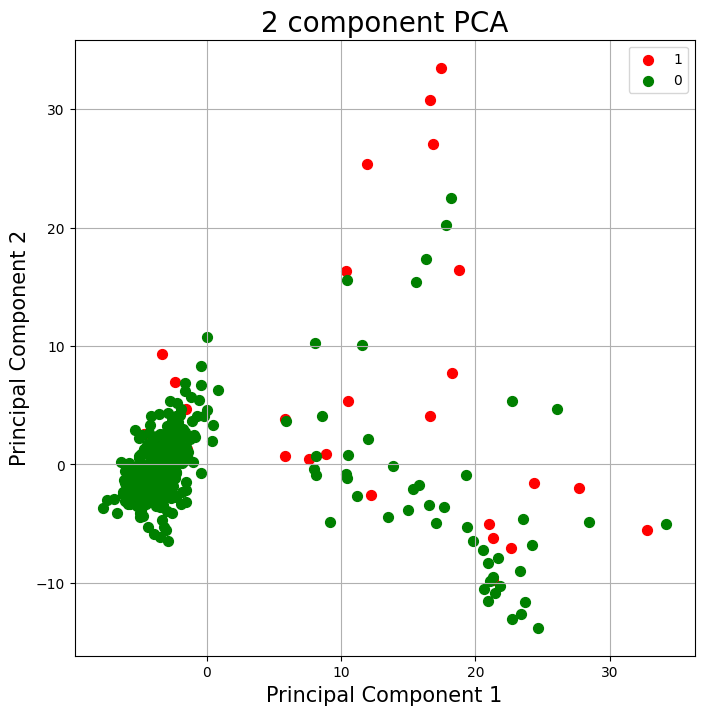

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['1', '0']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target_discrete'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

PCA is a dimensionality reduction technique, and useful especially for large datasets. This visual representation shows the first two principal components, that explain most of the variance of the data. In this case, PC1 explains 18% and PC2 7% of the variance. In this plot, red dots represent highly sensitive cell lines with high AUC, while the green ones are the ones with low sensitivity. From the plot we can see that PC1 quite well separate the sensitive cell lines from insensitive. However, separation is not perfect, since some of the red dots are detected around the clearly visible green cluster around 0 and other way round. This was expected, since together these two first components explained only 25% of variance the data. 

In [ ]:
#Example when using more PCs
#CCLE

pca = PCA(n_components=0.90) #as many components selected as needed to explain 90% of the variance
x_pca = pca.fit_transform(XER)


In [ ]:
print(x_pca.shape)
print(pca.explained_variance_ratio_) 
print (pca.explained_variance_ratio_.sum())
loadings = pca.components_


(406, 124)
[0.17741038 0.06555604 0.04848582 0.03355755 0.02749933 0.02689294
 0.02193801 0.0170569  0.01643125 0.0157011  0.01242827 0.0122149
 0.01169639 0.01132525 0.01007009 0.00948175 0.00928543 0.00906788
 0.00902707 0.00860308 0.00783944 0.00762597 0.00758196 0.00740131
 0.00730104 0.0070284  0.00668172 0.0064282  0.00616131 0.00610026
 0.00598562 0.00581012 0.00573036 0.00568637 0.00547845 0.00538843
 0.00508821 0.00504027 0.00495655 0.00487588 0.00471892 0.00467759
 0.00454366 0.00451359 0.00445696 0.00432289 0.00425079 0.00412752
 0.00406347 0.0040368  0.00397109 0.00393457 0.00384522 0.00378078
 0.0037348  0.00366346 0.00359975 0.00353543 0.00349545 0.00344908
 0.00337143 0.00333971 0.00325864 0.00322002 0.00318652 0.00316603
 0.00311053 0.00306667 0.00302594 0.00298348 0.00291594 0.0028491
 0.0027951  0.00276324 0.00271909 0.00267179 0.00263683 0.0025798
 0.00254278 0.00252592 0.00249475 0.00241266 0.00237841 0.00237233
 0.00233434 0.0023275  0.00226998 0.00223783 0.0022192

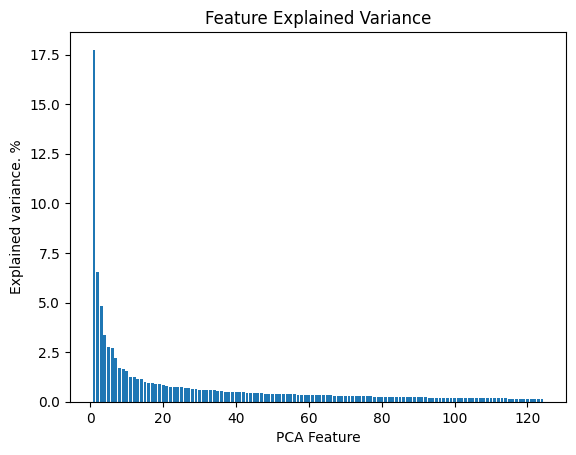

In [ ]:
plt.bar(
    range(1,len(pca.explained_variance_ratio_)+1),
    pca.explained_variance_ratio_ *100
    )
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance. %')
plt.title('Feature Explained Variance')
plt.show()

As this figure shows, the first two principal components explain only around 25% of the variance and as many as 124 PCs are needed to cover 90% of the variance of the data. 

### GDSC

In [ ]:
X_gdsc=gdsc.iloc[:,:-1]
X_gdsc = StandardScaler().fit_transform(X_gdsc)

In [ ]:
#mean is around 0 and std 1, so scaling was succesfull 

print(np.mean(X_gdsc))
print(np.std(X_gdsc))

-1.6215676333553913e-17
1.0


In [ ]:
#GDSC
from sklearn.decomposition import PCA
pca_test = PCA(n_components=2)
principalComponents_test = pca_test.fit_transform(X_gdsc)
principalDf_test = pd.DataFrame(data = principalComponents_test, columns = ['principal component 1', 'principal component 2'])

In [ ]:
#for some reason I am unable to concat the principalDf and test['target_discrete] dircetly. Doing this manual
#step seems to help.
ger=gdsc['target_discrete']
ger = ger.reset_index()
ger = ger.iloc[: , 1:]

In [ ]:
finalDf_test = pd.concat([principalDf_test, ger['target_discrete']], axis = 1)


In [ ]:
#Explained variances

print(pca_test.explained_variance_ratio_) 

PC1_test = "{:.1f}".format(pca_test.explained_variance_ratio_[0] * 100)
PC2_test = "{:.1f}".format(pca_test.explained_variance_ratio_[1] * 100)


[0.15363012 0.05396915]


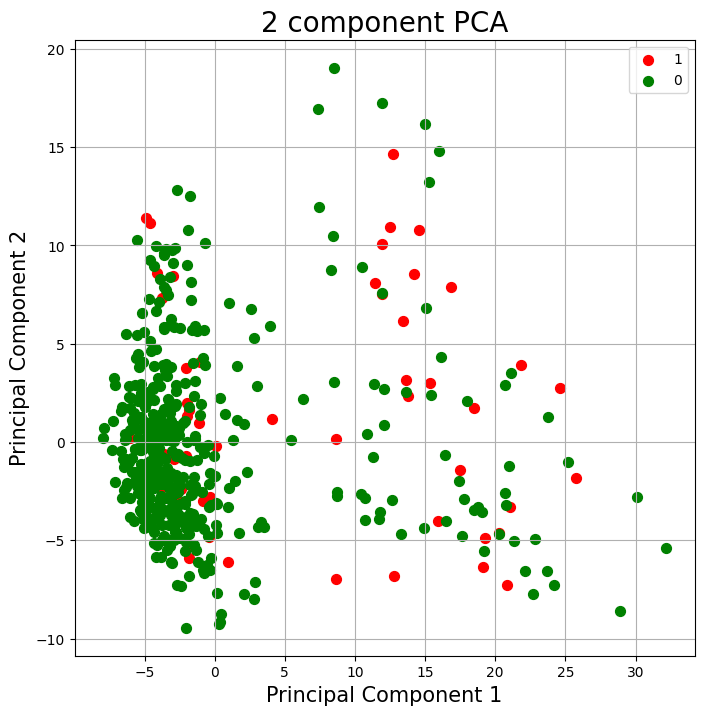

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['1', '0']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf_test['target_discrete'] == target
    ax.scatter(finalDf_test.loc[indicesToKeep, 'principal component 1']
               , finalDf_test.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

This figure represents the PCA of  GDSC dataset. Results are quite comparable to CCLE dataset. However, it can be observed that separation is not as good. PC1 explains 15% and PC2% of the variance of the data, which is a bit less than in CCLE dataset, which might explain worse separation. Still, we can detect clear cluster of green dots (cell lines with low sensitivity), but there are also red dots (cell lines with high sensitivity) present. Again, sensitive cell lines are not forming a clear cluster. 

In [ ]:
pca = PCA(n_components=0.90) #as many components selected as needed to explain 90% of the variance
x_pca2 = pca.fit_transform(X_gdsc)

In [ ]:
print(x_pca2.shape)
print(pca.explained_variance_ratio_) 
print (pca.explained_variance_ratio_.sum())
loadings = pca.components_

(509, 146)
[0.15363012 0.05396915 0.04773991 0.03826449 0.02758596 0.02555204
 0.01930398 0.0180182  0.01562725 0.01441321 0.01353585 0.0129531
 0.0115098  0.0111273  0.01037525 0.00963265 0.00947517 0.00881962
 0.00843541 0.00816641 0.00802628 0.00756081 0.00734502 0.00720265
 0.00706193 0.00652531 0.00639714 0.00626829 0.00618001 0.0059506
 0.00575033 0.00562633 0.00542713 0.00524064 0.00518735 0.00517134
 0.00503889 0.00496146 0.004811   0.00467132 0.00464781 0.00448213
 0.00441462 0.00438111 0.00426243 0.00422873 0.0041837  0.0040682
 0.00405266 0.00400401 0.00393165 0.00387211 0.00375494 0.00369689
 0.0036616  0.0036272  0.00355507 0.00353643 0.00350007 0.0034162
 0.0034055  0.00335062 0.0032723  0.00325276 0.00318547 0.00313987
 0.00310217 0.00308183 0.00306197 0.00300845 0.00296939 0.00291475
 0.00288874 0.00286811 0.00278665 0.00274468 0.00272624 0.00268283
 0.00265355 0.00264699 0.00261823 0.00260387 0.00255951 0.00251669
 0.00249374 0.00245562 0.00243353 0.00240817 0.0023765 

146 principal components are needed to explain 90% of the variance of the GDSC dataset, which is more than in CCLE dataset.

### 3.2 Collinearity of the features in CCLE mRNA training data <a id="section_3.3"></a>

Collinearity means co-dependence between two predictor variables, whereas multicollinearity means that several predictors are correlated. In regression analysis multicollinearity makes the model's coefficients very sensitive to small chances and model might capture the noise of the training data, leading to overfitting. 

There are several statistical methods to assess if there are any multicollinearity among variables. With Pearson linear correlation test one can assess if any of the variables have a high (> 0.8) correlation with some other variable. A handy way to visualize the results is to plot the correlation results into a heatmap.

Let's first count how many correlating features are present in the dataset. Let's arbitrarily set 0.6 as threshold and count the number of feature pairs that have this correlation value.

Text(0.5, 1.0, 'Heatmap, CCLE')

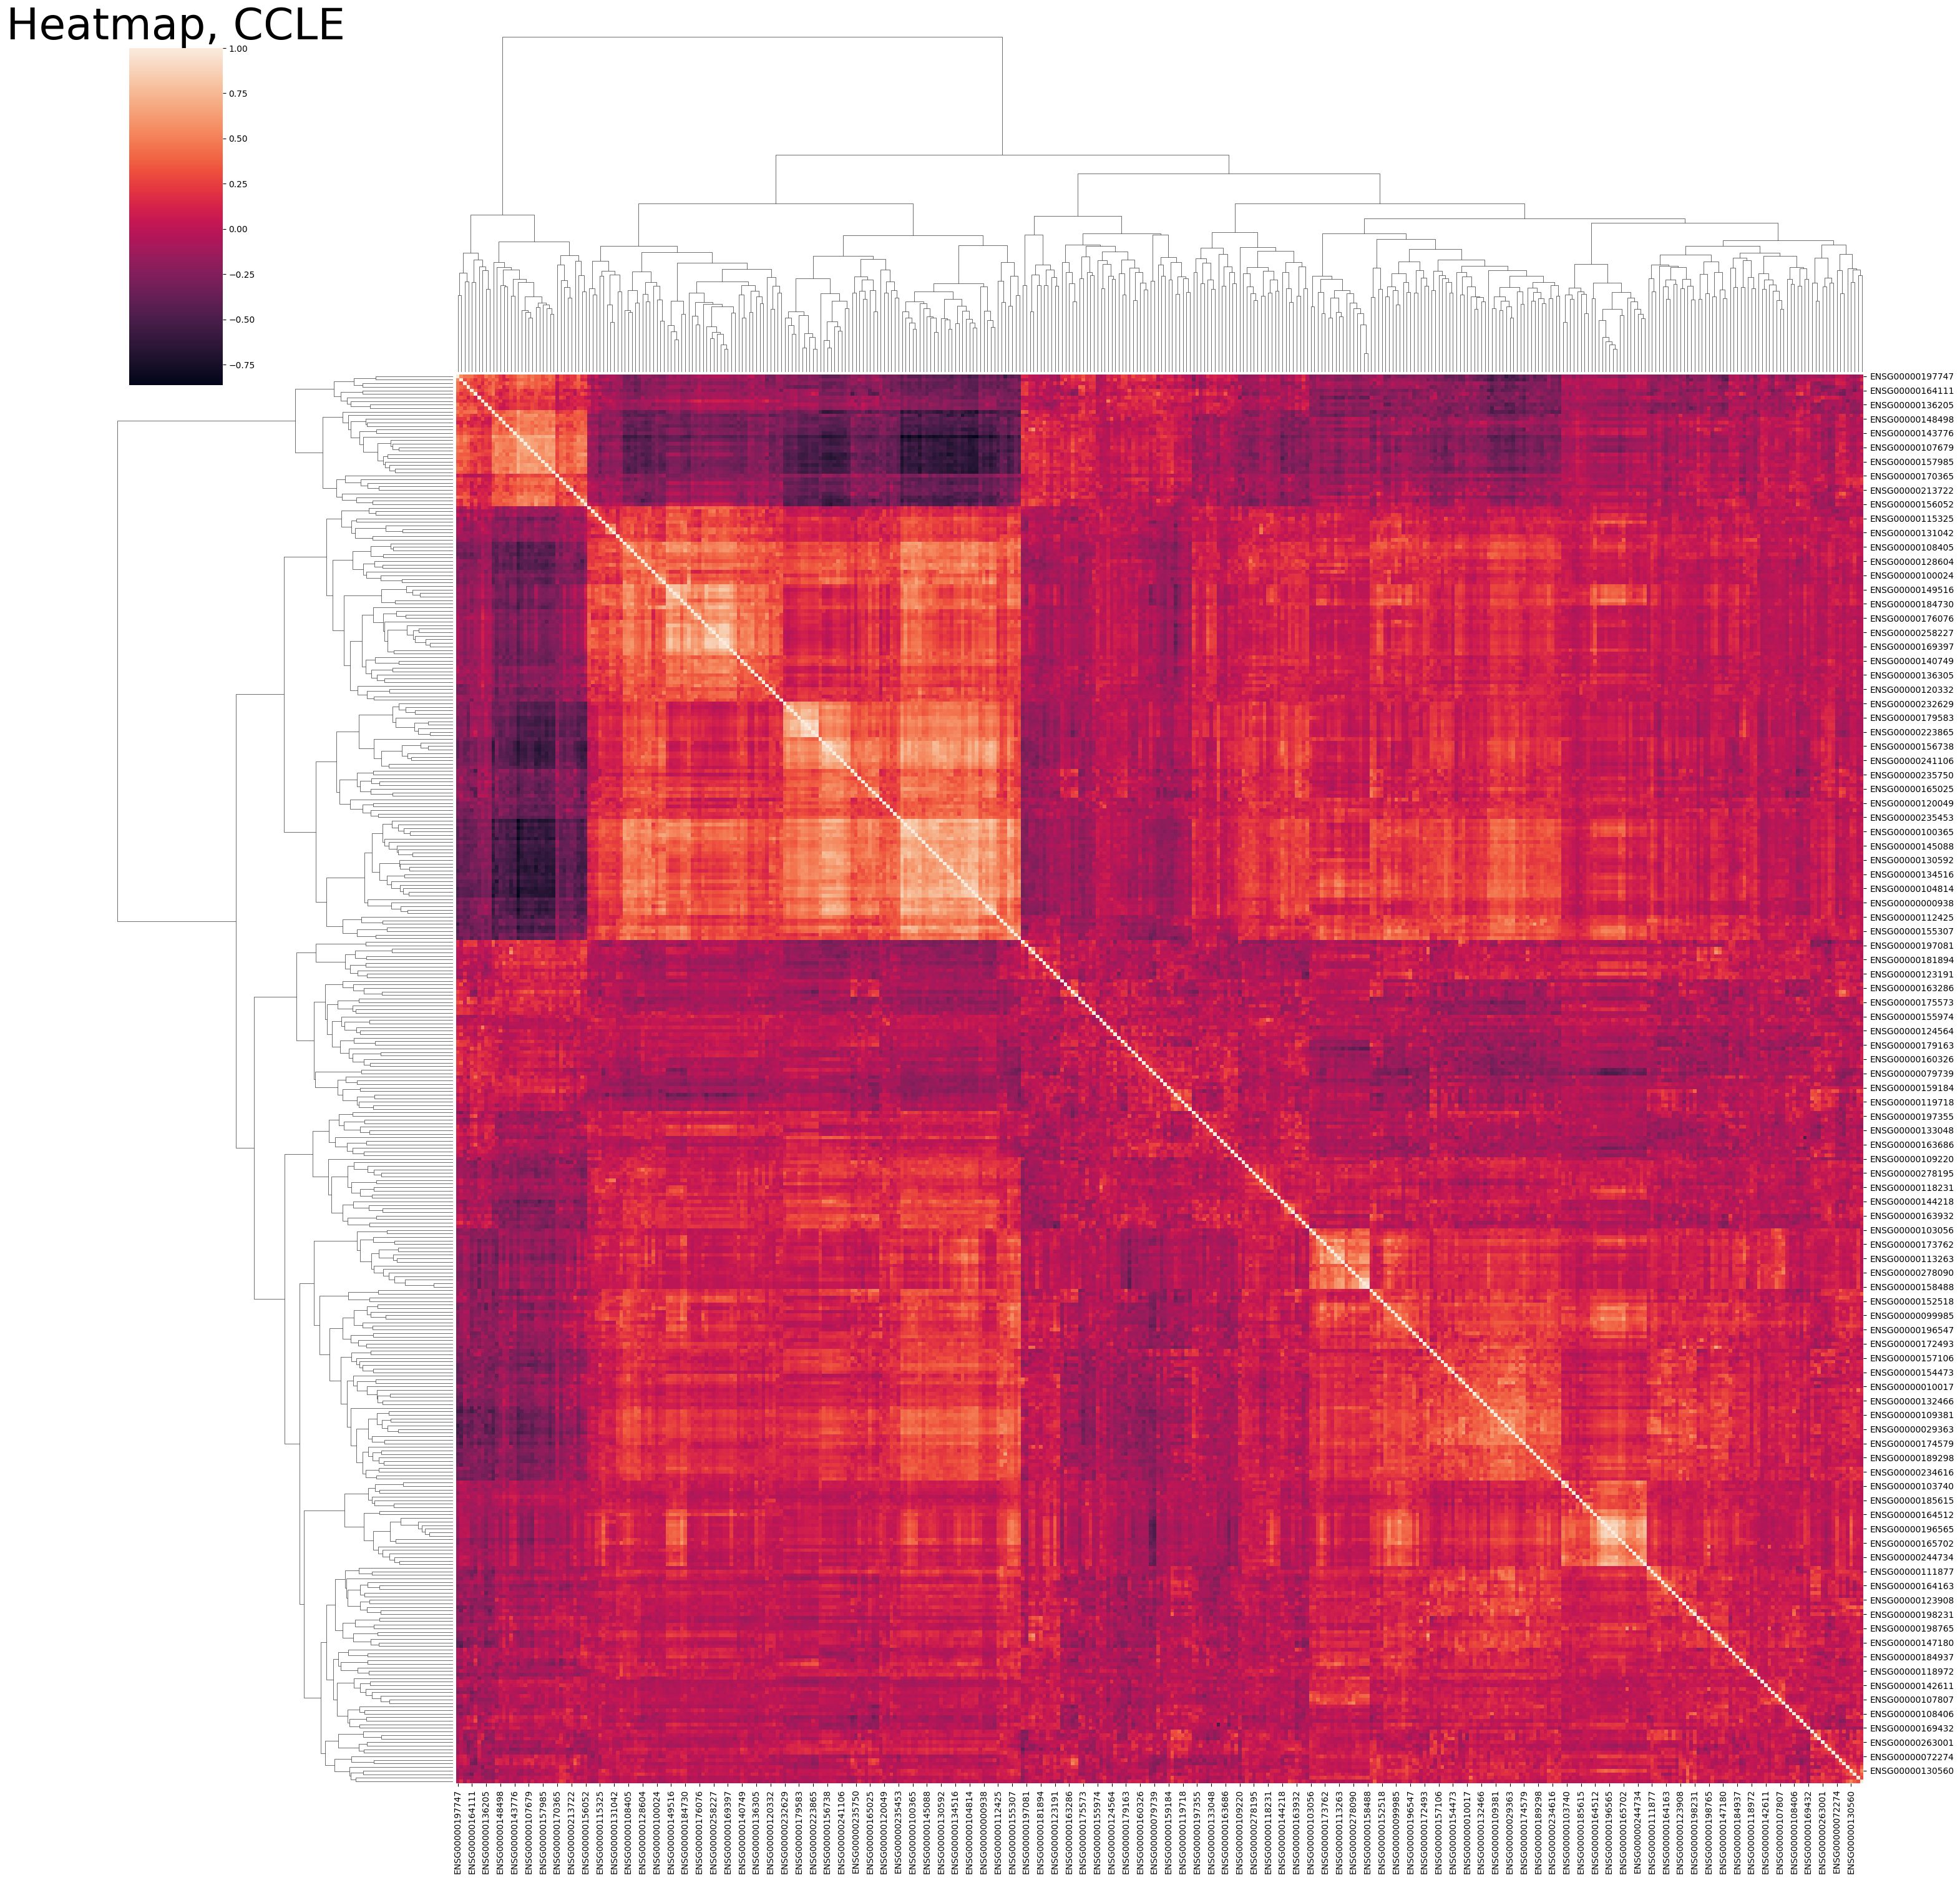

In [ ]:
matrix=ccle.corr(method='pearson', min_periods=1)

sns.clustermap(matrix, figsize=(30,30)) ;

plt.title(('Heatmap, CCLE'), fontsize = 50) 

In heatmap each row represents a gene and each column a sample, while the color and intensity shows the correlation. Lighter color indicates higher and darker lower correlation. From this heatmap generated from CCLE dataset we can clearly observe some lighter areas, which are representing correlated features. In genetics this is common, since many genes participate in same biological processes and are affecting each others expression. Therefore, these genes can be observed to cluster together. 

In [ ]:
#showing only the pairs with equal or higher correlation than 0.6

corr = matrix

kot = corr[corr>=.6]
#plt.figure(figsize=(20,20))
#sns.heatmap(kot, cmap="Greens")

In [ ]:
#Here we can see the pairs of features that are highly correlated

# Retain upper triangular values of correlation matrix and make Lower triangular values Null
corr_mat=matrix

upper_corr_mat = corr_mat.where(
    np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
  
# Convert to 1-D series and drop Null values
unique_corr_pairs = upper_corr_mat.unstack().dropna()
  
# Sort correlation pairs
sorted_mat = unique_corr_pairs.sort_values()
print(sorted_mat)

ENSG00000104894  ENSG00000061676   -0.862146
ENSG00000122122  ENSG00000061676   -0.862056
ENSG00000061676  ENSG00000015285   -0.839237
ENSG00000120280  ENSG00000061676   -0.836832
ENSG00000061676  ENSG00000010671   -0.826644
                                      ...   
ENSG00000158488  ENSG00000158485    0.930047
ENSG00000169397  ENSG00000169385    0.931714
ENSG00000172232  ENSG00000169385    0.932875
ENSG00000231389  ENSG00000204287    0.935998
ENSG00000204287  ENSG00000196126    0.939110
Length: 78210, dtype: float64
/tmp/ipykernel_242/1397201859.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))


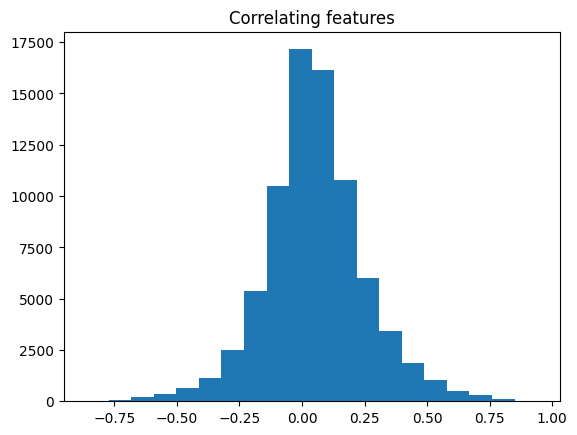

In [ ]:
plt.title("Correlating features")
plt.hist(sorted_mat, bins=20) ;


Even though we have 824 correlated features (Pearson's correlation coefficient > 0.6), most of the features have low correlations, as seen from the histogram above. 

In [ ]:
#Number of correlated features
correlated_features=[]

for i in sorted_mat:
    if i >= 0.6:
        correlated_features.append(i)

len(correlated_features)

824

## 4. Model training, validation and testing <a id="section_4"></a>

In this section we are focusing on the first objective of our project, which was to identify biomarkers (genes) of Nilotinib response from cancer cell line data using supervised learning techniques. Here we will combine grid search with nested cross validation within the CCLE dataset to fine tune the hyperparameters of selected models, and use external GDSC dataset for model validation. 

In nested cross-validation, after splitting the CCLE data into test and train sets,  training data is further divided into training and validation sets. We collect performance metrics for all these datasets; train, validation and test. Additionally, we have external GDSC dataset for validation and model performance is also recorded within this dataset. 

### 4.1 Training classifiers on CCLE mRNA data and testing their accuracy <a id="section_4.1"></a>

We decided to use KNN, Random Forest and Naive Bayes classifiers in the classification task. Accuracy score is used as evaluation metric. For classifiers, we are using Stratified cross-validation for outer loop to take into account non-balanced groups of target variable.

Below each model the boxplot containing accuracies for training and validation sets (divided from original training set) calculated during grid search is shown, as well as the standard deviations in accuracies for training and validation sets. However, the results will be discussed in section 4.2, which summarizes the results of all classifiers. 

The motivation for each algorithm goes as following. KNN as a non-parametric algorithm is easy to use and doesn't require extensive parameter tuning. Also, it doesn't have strict requirments for the quality of data and is therefore a natural first choice.

PCA analysis shoved that the data might be somewhat overlapping. In smaller datasets, Support Vector Machine is usually able to give the most accurate results. Hoewever, the algorithm isn't usually able to handle too much of noise in the data. Naive Bayes classifier is the algortihm, which suffers the least from noise or overlapping classes, although it is usually one of the least accurate algorithm

Random Forest is one the most used algorithms. It is highly accurate and works well on different datasets. Therefore it is expected to give the best performance. Another benefit to the algorithm is the ability to check which features (genes) are most important for the classification.

In [ ]:
#Packages for the models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

#Packages for grid search, cross-validation and model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold


First, we decided to test K-Nearest neighbors classifier. 

In [ ]:
#KNN

#data
X=ccle.iloc[:,:-2]
y=ccle['target_discrete']

#convert from numpy to pandas
X= pd.DataFrame(X)
#y=pd.DataFrame(y)

my_seed = 5
scorers = 'accuracy'
model = KNeighborsClassifier()
outer_splits =10
inner_splits = 3

# creating a dictionary containing potential values of parameters
k_range = list(range(1,30))
l_range = list(range(1,50))
params = dict(n_neighbors=k_range, leaf_size=l_range)
# configure the cross-validation procedure
cv_outer = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=my_seed)
#for result storage
test_results_knn = list()
training_results_knn = list()
training_results_sd_knn = list()
validation_results_knn=list()
validation_results_sd_knn= list()
# enumerate splits
for train_ix, test_ix in cv_outer.split(X,y):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    #imputating
    for column in X_train: 
        X_train[column] = X_train[column].fillna(X_train[column].median()) 
    for columni in X_test:
        X_test[columni] = X_test[columni].fillna(X_test[columni].median()) 
    #scaling
    scaler = StandardScaler()
    scaler.fit(X_train)  # fit only on training data
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)  # apply same transformation to test data
    # configure the inner cross-validation strategy
    cv_inner = KFold(n_splits=inner_splits, shuffle=True, random_state=my_seed)
    # define search
    search = GridSearchCV(model,params, scoring=scorers, cv=cv_inner, return_train_score=True)
    # execute search
    result = search.fit(X_train, y_train)
    # Obtain scores
    train_scores_mean = (search.cv_results_['mean_train_score']) 
    train_scores_sd = (search.cv_results_['std_train_score'])
    validation_scores_mean = (search.cv_results_['mean_test_score']) 
    validation_scores_sd = (search.cv_results_['std_test_score'])
    # predict on test set
    best_model_knn= result.best_estimator_
    yhat = best_model_knn.predict(X_test) 
    # evaluate the model             
    test_score = accuracy_score(y.iloc[test_ix], yhat) 
    # store the results
    training_results_knn.append(train_scores_mean)
    training_results_sd_knn.append(train_scores_sd)
    validation_results_knn.append(validation_scores_mean)
    validation_results_sd_knn.append(validation_scores_sd)
    test_results_knn.append(test_score)

#Print the best score and parameters
print(result.best_score_)
print(result.best_params_)

  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/2292771495.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/2292771495.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/2292771495.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [ ]:
#External test set
X_gdsc=gdsc.iloc[:,:-2]
y_gdsc= gdsc['target_discrete']

#fit the best model to external test set
X_gdsc=StandardScaler().fit_transform(X_gdsc)

#prediction
yhat_knn = best_model_knn.predict(X_gdsc) 

#evaluation
gdsc_results_knn= accuracy_score(y_gdsc, yhat_knn) 

The mean of the standard deviations in training accuracies computed during CV iterations is: 0.008733094866464513
The mean of the standard deviations in test accuracies computed during CV iterations is: 0.018414123665968934


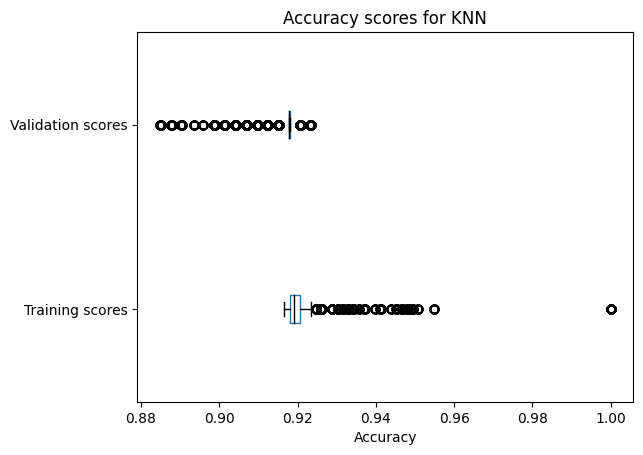

In [ ]:
#from list of arrays to one array
training_results_knn=np.concatenate(training_results_knn, axis=0)
validation_results_knn=np.concatenate(validation_results_knn, axis=0)

#dataframe
all_scores_knn = {
    "Training scores": training_results_knn,
    "Validation scores": validation_results_knn,
    #"GDSC scores": gdsc_results_knn
}
all_scores_knn = pd.DataFrame(all_scores_knn)

#visualization
color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores_knn.plot.box(color=color, vert=False)
plt.xlabel("Accuracy")
_ = plt.title("Accuracy scores for KNN")

sd_training_knn=np.mean(training_results_sd_knn)
sd_val_knn=np.mean(validation_results_sd_knn)

#SDs from training (train + validation)
print("The mean of the standard deviations in training accuracies computed during CV iterations is:",np.mean(sd_training_knn))
print("The mean of the standard deviations in test accuracies computed during CV iterations is:", np.mean(sd_val_knn))



Next, we tested Random Forest. 

In [ ]:
#Random forest

# manual nested cross-validation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X=ccle.iloc[:,:-2]
y=ccle['target_discrete']

#convert from numpy to pandas
X= pd.DataFrame(X)
#y=pd.DataFrame(y)

my_seed = 5
scorers = 'accuracy'
model = RandomForestClassifier()
outer_splits = 10   
inner_splits = 3  

# creating a dictionary containing potential values of parameters
params = {'bootstrap': [True, False],
 'max_depth': [3,5,10,None],
 'criterion': ['gini', 'entropy', 'log_loss'],
 'min_samples_leaf': [2, 5, 10],
 'min_samples_split': [2, 5, 10] ,
 'n_estimators': [10, 50, 100]}
# configure the cross-validation procedure
cv_outer = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=my_seed)

test_results_rf = list()
training_results_rf = list()
training_results_sd_rf = list()
validation_results_rf=list()
validation_results_sd_rf= list()
# enumerate splits
for train_ix, test_ix in cv_outer.split(X,y):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    #imputating
    for column in X_train: 
        X_train[column] = X_train[column].fillna(X_train[column].median()) 
    for columni in X_test:
        X_test[columni] = X_test[columni].fillna(X_test[columni].median()) 
    #scaling
    scaler = StandardScaler()
    scaler.fit(X_train)  # fit only on training data
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)  # apply same transformation to test data
    # configure the inner cross-validation strategy
    cv_inner = KFold(n_splits=inner_splits, shuffle=True, random_state=my_seed)
    # define search
    search = GridSearchCV(model, params, scoring=scorers, cv=cv_inner, return_train_score=True)
    # execute search
    result = search.fit(X_train, y_train)
    # Obtain scores
    train_scores_mean = (search.cv_results_['mean_train_score']) 
    train_scores_sd = (search.cv_results_['std_train_score'])
    validation_scores_mean = (search.cv_results_['mean_test_score']) 
    validation_scores_sd = (search.cv_results_['std_test_score'])
    # predict on test set
    best_model_rf= result.best_estimator_
    yhat = best_model_rf.predict(X_test) 
    # evaluate the model
    test_score = accuracy_score(y.iloc[test_ix], yhat) 
    #print(confusion_matrix(y.iloc[test_ix], yhat))
    # store the results
    training_results_rf.append(train_scores_mean)
    training_results_sd_rf.append(train_scores_sd)
    validation_results_rf.append(validation_scores_mean)
    validation_results_sd_rf.append(validation_scores_sd)
    test_results_rf.append(test_score)

#Print the best score and parameters
print(result.best_score_)
print(result.best_params_)


  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/1631263170.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/1631263170.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/1631263170.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [ ]:
#External test set
X_gdsc=gdsc.iloc[:,:-2]
y_gdsc= gdsc['target_discrete']

#fit the best model to external test set
X_gdsc=StandardScaler().fit_transform(X_gdsc)

#prediction
yhat_rf = best_model_rf.predict(X_gdsc) 

#evaluation
gdsc_results_rf= accuracy_score(y_gdsc, yhat_rf) 

The mean of the standard deviations in training accuracies computed during CV iterations is: 0.006589912043361709
The mean of the standard deviations in test accuracies computed during CV iterations is: 0.01791304841823924


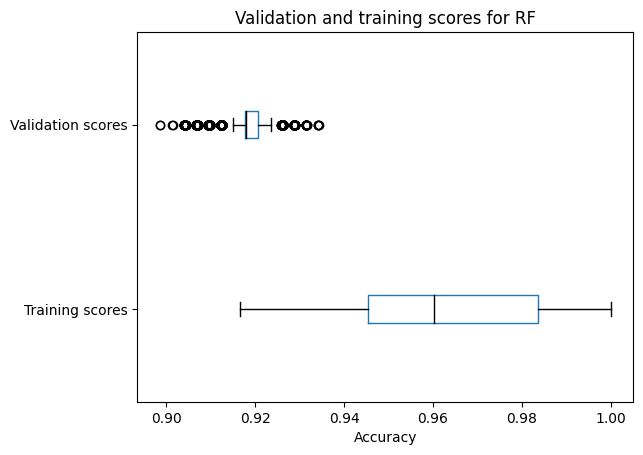

The mean of the standard deviations in training accuracies computed during CV iterations is: 0.006591999133946535
The mean of the standard deviations in test accuracies computed during CV iterations is: 0.017859225066336717


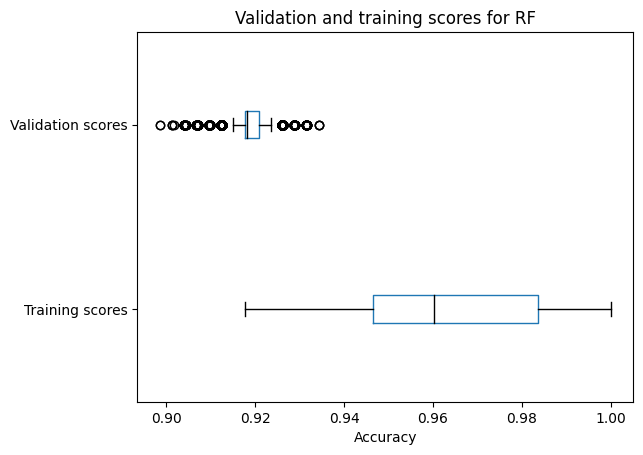

The mean of the standard deviations in training accuracies computed during CV iterations is: 0.00651254122014688
The mean of the standard deviations in test accuracies computed during CV iterations is: 0.017958963528762556


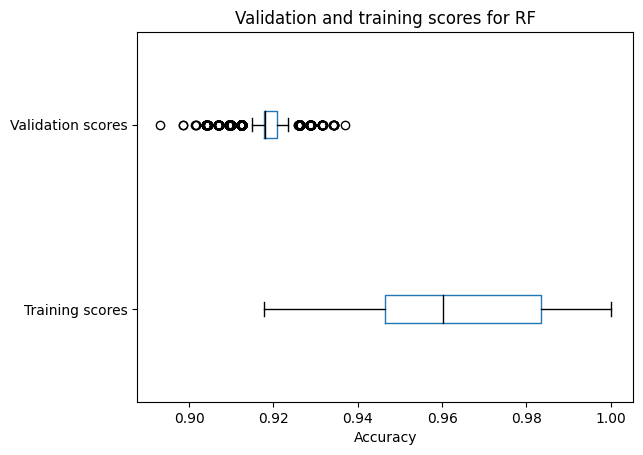

In [ ]:
#from list of arrays to one array
training_results_rf=np.concatenate(training_results_rf, axis=0)
validation_results_rf=np.concatenate(validation_results_rf, axis=0)

#dataframe
all_scores_rf = {
    "Training scores": training_results_rf,
    "Validation scores": validation_results_rf,
}
all_scores_rf = pd.DataFrame(all_scores_rf)

#visualization
color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores_rf.plot.box(color=color, vert=False)
plt.xlabel("Accuracy")
_ = plt.title("Validation and training scores for RF")

#SDs


print("The mean of the standard deviations in training accuracies computed during CV iterations is:", np.mean(training_results_sd_rf ))
print("The mean of the standard deviations in test accuracies computed during CV iterations is:", np.mean(validation_results_sd_rf))

Lastly, we test Gaussian Naive Bayes 

In [ ]:
#Naive Bayes

my_seed = 5
scorers = 'accuracy'
model = GaussianNB()
outer_splits =10
inner_splits = 3

X=ccle.iloc[:,:-2]
y=ccle['target_discrete']

#convert from numpy to pandas
X= pd.DataFrame(X)
#y=pd.DataFrame(y)

# creating a dictionary containing potential values of parameters
params = {'var_smoothing': np.logspace(0,-9, num=100)}
# configure the cross-validation procedure
cv_outer = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=my_seed)
#for result storage
test_results_nb = list()
training_results_nb = list()
training_results_sd_nb = list()
validation_results_nb=list()
validation_results_sd_nb= list()
# enumerate splits
for train_ix, test_ix in cv_outer.split(X,y):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    #imputating
    for column in X_train: 
        X_train[column] = X_train[column].fillna(X_train[column].median()) 
    for columni in X_test:
        X_test[columni] = X_test[columni].fillna(X_test[columni].median()) 
    #scaling
    scaler = StandardScaler()
    scaler.fit(X_train)  # fit only on training data
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)  # apply same transformation to test data
    # configure the inner cross-validation startegy
    cv_inner = KFold(n_splits=inner_splits, shuffle=True, random_state=my_seed)
    # define search
    search = GridSearchCV(model, params, scoring=scorers, cv=cv_inner, return_train_score=True)
    # execute search
    result = search.fit(X_train, y_train)
    # Obtain scores
    train_scores_mean = (search.cv_results_['mean_train_score']) 
    train_scores_sd = (search.cv_results_['std_train_score'])
    validation_scores_mean = (search.cv_results_['mean_test_score']) 
    validation_scores_sd = (search.cv_results_['std_test_score'])
    # predict on test set
    best_model_nb= result.best_estimator_
    yhat = best_model_nb.predict(X_test) 
    # evaluate the model.              
    test_score = accuracy_score(y.iloc[test_ix], yhat)
    # store the results
    training_results_nb.append(train_scores_mean)
    training_results_sd_nb.append(train_scores_sd)
    validation_results_nb.append(validation_scores_mean)
    validation_results_sd_nb.append(validation_scores_sd)
    test_results_nb.append(test_score)

#Print the best score and parameters
print(result.best_score_)
print(result.best_params_)
    

  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/558938273.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/558938273.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/558938273.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [ ]:
#External test set
X_gdsc=gdsc.iloc[:,:-2]
y_gdsc= gdsc['target_discrete']

#fit the best model to external test set
X_gdsc=StandardScaler().fit_transform(X_gdsc)

#prediction
yhat_nb = best_model_nb.predict(X_gdsc) 

#evaluation
gdsc_results_nb= accuracy_score(y_gdsc, yhat_nb) 

The mean of the standard deviations in training accuracies computed during CV iterations is: 0.01833517056905739
The mean of the standard deviations in test accuracies computed during CV iterations is: 0.019569713234774758


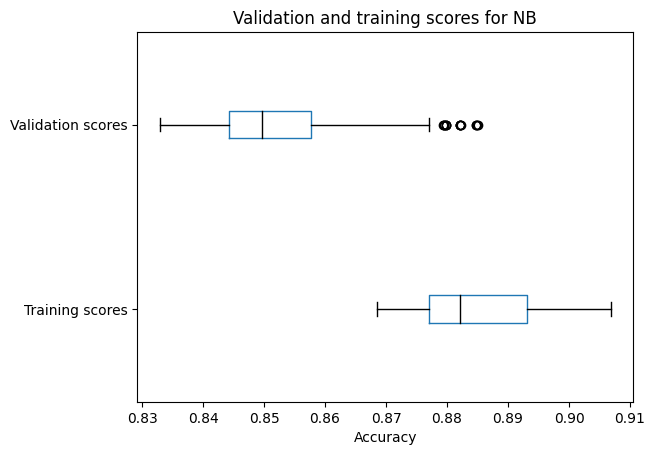

The mean of the standard deviations in training accuracies computed during CV iterations is: 0.01833517056905739
The mean of the standard deviations in test accuracies computed during CV iterations is: 0.019569713234774758


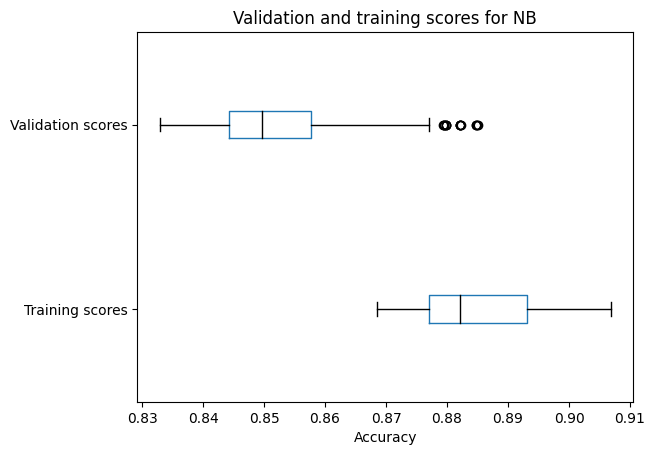

The mean of the standard deviations in training accuracies computed during CV iterations is: 0.01833570430280119
The mean of the standard deviations in test accuracies computed during CV iterations is: 0.019576008415228118


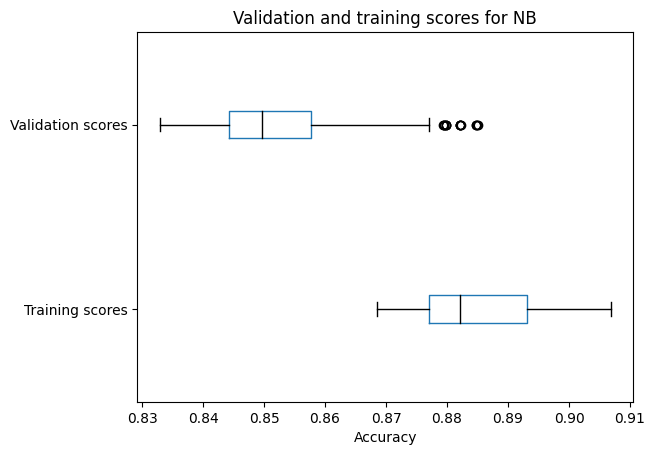

In [ ]:
#from list of arrays to one array
training_results_nb=np.concatenate(training_results_nb, axis=0)
validation_results_nb=np.concatenate(validation_results_nb, axis=0)

#dataframe
all_scores_nb = {
    "Training scores": training_results_nb,
    "Validation scores": validation_results_nb,
}
all_scores_nb = pd.DataFrame(all_scores_nb)

#visualization
color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores_nb.plot.box(color=color, vert=False)
plt.xlabel("Accuracy")
_ = plt.title("Validation and training scores for NB")

print("The mean of the standard deviations in training accuracies computed during CV iterations is:", np.mean(training_results_sd_nb ))
print("The mean of the standard deviations in test accuracies computed during CV iterations is:", np.mean(validation_results_sd_nb))

### 4.2 Analysis of all classifiers <a id="section_4.3"></a>

* Compare the performance of the trained model using training and test sets. Also show the performance on the external (GDSC) set.

* Collect the performance metrics in a dataframe and show/compare the results with tables and graphical illustrations. 

<img src="model_comp.png" width="800"/>

In [ ]:
#dataframe including scores for all classifiers

df1=all_scores_knn
df2=all_scores_rf
df3=all_scores_nb


all_scores_mix= pd.concat([df1, df2, df3], axis=1)

all_scores_mix.columns =['Training score KNN', 'Validation score KNN', 'Training score RF', 'Validation score RF', 'Training score NB', 'Validation score NB']

all_scores_mix

Training score KNN  Validation score KNN  Training score RF  \
0                1.000000              0.884839           0.957521   
1                0.945192              0.898546           0.954783   
2                0.941077              0.890327           0.960270   
3                0.924644              0.904033           0.958904   
4                0.921901              0.895791           0.954789   
...                   ...                   ...                ...   
14205            0.918033              0.918033                NaN   
14206            0.918033              0.918033                NaN   
14207            0.918033              0.918033                NaN   
14208            0.918033              0.918033                NaN   
14209            0.918033              0.918033                NaN   

       Validation score RF  Training score NB  Validation score NB  
0                 0.912252           0.905496             0.884817  
1                 0.912252           0.898643             0.882085  
2                 0.920449           0.897266             0.884817  
3                 0.914984           0.891779             0.884839  
4                 0.923204           0.889035             0.879375  
...                    ...                ...                  ...  
14205                  NaN                NaN                  NaN  
14206                  NaN                NaN                  NaN  
14207                  NaN                NaN                  NaN  
14208                  NaN                NaN                  NaN  
14209                  NaN                NaN                  NaN  

[14210 rows x 6 columns]

Training score KNN  Validation score KNN  Training score RF  \
0                1.000000              0.884839           0.952045   
1                0.945192              0.898546           0.954783   
2                0.941077              0.890327           0.954794   
3                0.924644              0.904033           0.953406   
4                0.921901              0.895791           0.956160   
...                   ...                   ...                ...   
14205            0.918033              0.918033                NaN   
14206            0.918033              0.918033                NaN   
14207            0.918033              0.918033                NaN   
14208            0.918033              0.918033                NaN   
14209            0.918033              0.918033                NaN   

       Validation score RF  Training score NB  Validation score NB  
0                 0.912252           0.905496             0.884817  
1                 0.914984           0.898643             0.882085  
2                 0.917717           0.897266             0.884817  
3                 0.914939           0.891779             0.884839  
4                 0.917717           0.889035             0.879375  
...                    ...                ...                  ...  
14205                  NaN                NaN                  NaN  
14206                  NaN                NaN                  NaN  
14207                  NaN                NaN                  NaN  
14208                  NaN                NaN                  NaN  
14209                  NaN                NaN                  NaN  

[14210 rows x 6 columns]

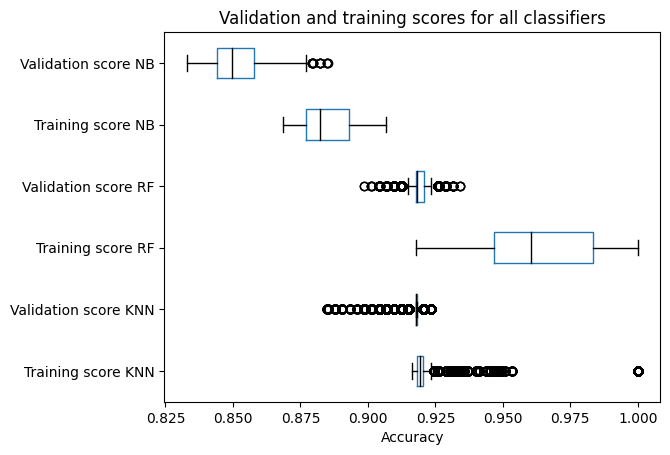

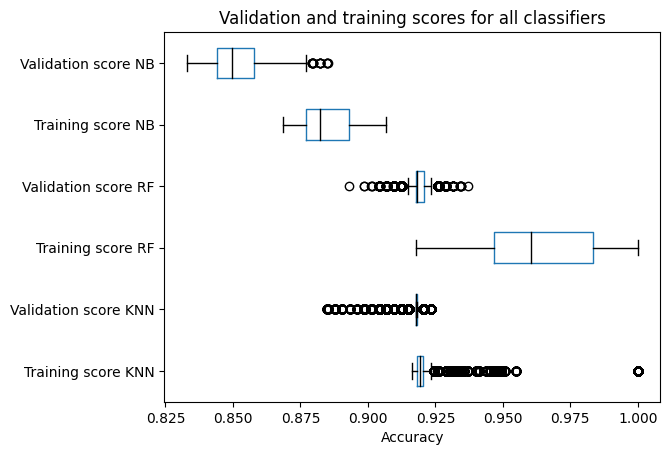

In [ ]:
#Visualization of the scores of all classifiers

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores_mix.plot.box(color=color, vert=False)
plt.xlabel("Accuracy")
_ = plt.title("Validation and training scores for all classifiers")


This figure summarizes the validation and training scores of all used classifiers. As earlier mentioned, in Nested CV the training set is divided into training and validation sets. The boxplot above represents the accuracies for these training and validation sets computed during grid search. From this figure we can see, that the performance of the Random Forest classifier is very good, median of the accuracy score within validation set is around 0.92 and over 0.95 within training set. 

Means of the standard deviations are calculated for training and validation sets (split from original training set during nested cross-validation). 

- For KNN, mean of the standard deviations in accuracies were 0.009 and 0.02 for training and validation sets, respectively. 

- For Random Forest, mean of the standard deviations in accuracies were 0.007 and 0.02 for training and validation sets, respectively. 

- For Gaussian Naive Bayes, mean of the standard deviations in accuracies was 0.02  for both training and validation sets.  

In [ ]:

knn_train_mean=np.mean(training_results_knn)
knn_test_mean=np.mean(test_results_knn)
knn_gdsc_mean=np.mean(gdsc_results_knn)
nb_train_mean=np.mean(training_results_nb)
nb_test_mean=np.mean(test_results_nb)
nb_gdsc_mean=np.mean(gdsc_results_nb)
rf_train_mean=np.mean(training_results_rf)
rf_test_mean=np.mean(test_results_rf)
rf_gdsc_mean=np.mean(gdsc_results_rf)


train_cl_acc_mean= knn_train_mean, nb_train_mean, rf_train_mean
test_cl_acc_mean = knn_test_mean, nb_test_mean, rf_test_mean
gdsc_cl_acc_means = knn_gdsc_mean, nb_gdsc_mean, rf_gdsc_mean
#train_cl_f1_means = 
#test_cl_f1_means = 
#GDSC_cl_f1_means = 

data_eval_cl = pd.DataFrame({'model':["KNN","Gaussian Naive Bayes","Random Forest"],
                             'train_acc': train_cl_acc_mean,
                             'test_acc': test_cl_acc_mean,
                             'gdsc_acc': gdsc_cl_acc_means})
                             #'train_f1': train_cl_f1_list,
                             #'test_f1': test_cl_f1_list,
                             #'gdsc_f1': GDSC_cl_f1_list})

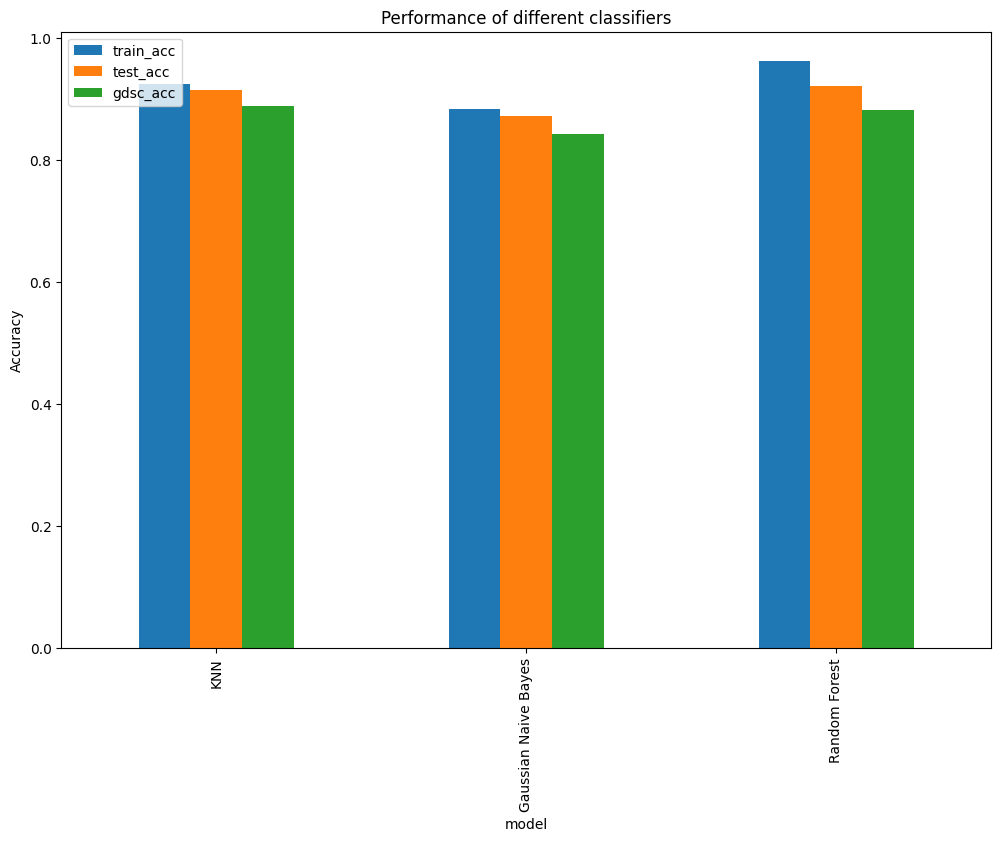

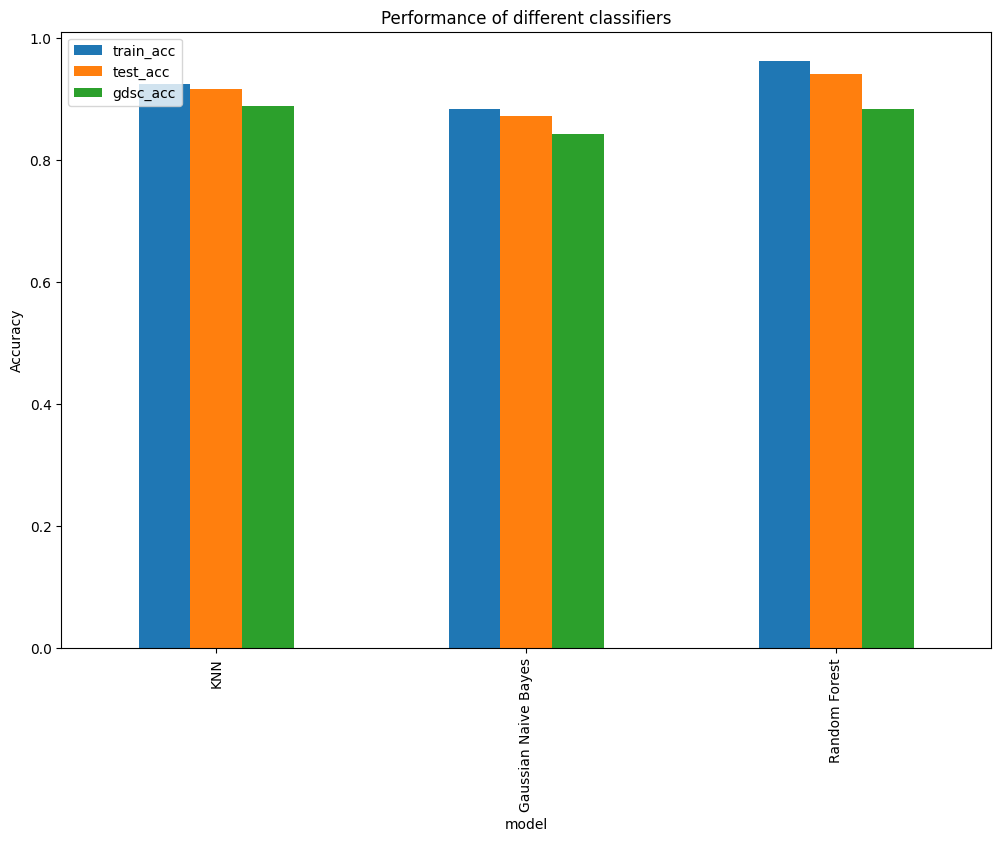

In [ ]:
#Tässä plotissa ei nyt ole niitä "validation" tuloksia.

data_eval_cl.plot(x='model', y=['train_acc','test_acc','gdsc_acc'],
                  kind="bar", figsize=(12,8), title='Performance of different classifiers')
plt.ylabel("Accuracy")
plt.legend(loc='upper left')
plt.show()

Boxplot here shows the accuracies for training and test sets (CCLE) and external test set (GDSC) for all tested classifiers. Performance of all the models is relatively good, but according to these results Random Forest seems to perform best. There are now signs of significant overfitting. 

### 4.3 Training regressors on CCLE mRNA data and testing their performance <a id="section_4.3"></a>



In this part of the project, three different regressors are used to get a numeric estimate for a cell lines target value based on its gene expression, rather than trying to predict a discrete class. 

A simple linear regression, and regularization based models Lasso and ElasticNet are selected for testing. Ridge regression wasn't included since RG includes all the features in the regression model even if some of these features are irrelevant.  Regularization based methods are able to take into account multicollinearity and uninformative features. Based on our exploratory data-analysis, our data seems to to contain correlating features and probably uninformative features as well, which highlights the usefulness of regularization based methods in our dataset. Regularization techniques allow us to decrease the variance of the model by adding bias such that the total error is reduced. Mean squared error is used as evaluation metric. 

Similarly as with classifiers, below each model the boxplot containing accuracies for training and validation sets (divided from original training set) calculated during grid search is shown, as well as the standard deviations in accuracies for training and validation sets. However, the results will be discussed in section 4.4, which summarizes the results of all regressors. 

In [ ]:
#packages for models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

#evaluation metrics for regression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


First, we tested Lasso. 

In [ ]:
#Lasso


X=ccle.iloc[:,:-2]
y=ccle['target']

#convert from numpy to pandas
X= pd.DataFrame(X)
#y=pd.DataFrame(y)

my_seed = 490
scorers = "neg_mean_squared_error"
model = Lasso()
outer_splits =10
inner_splits = 3

# creating a dictionary containing potential values of parameters
params = {'alpha':[0.0001, 0.001, 0.01,0.02,0.03,0.04, 0.05, 0.06,0.07, 0.08, 1, 2, 5, 10, 20], 
        'tol': [1e-2]}
# configure the cross-validation procedure
cv_outer = KFold(n_splits=outer_splits, shuffle=True, random_state=my_seed)
# enumerate splits
test_results_lasso = list()
training_results_lasso = list()
training_results_sd_lasso = list()
validation_results_lasso=list()
validation_results_sd_lasso= list()
for train_ix, test_ix in cv_outer.split(X,y):
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    #impute
    for column in X_train: 
        X_train[column] = X_train[column].fillna(X_train[column].median()) 
    for columni in X_test:
        X_test[columni] = X_test[columni].fillna(X_test[columni].median()) 
    #scaling
    scaler = StandardScaler()
    scaler.fit(X_train)  # fit only on training data
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)  # apply same transformation to test data
    # configure the inner cross-validation startegy
    cv_inner = KFold(n_splits=inner_splits, shuffle=True, random_state=my_seed)
    # define search
    search = GridSearchCV(model, params, scoring=scorers, cv=cv_inner, return_train_score=True)
    # execute search
    result = search.fit(X_train, y_train)
    # Obtain scores
    train_scores_mean = (search.cv_results_['mean_train_score']) 
    train_scores_sd = (search.cv_results_['std_train_score'])
    validation_scores_mean = (search.cv_results_['mean_test_score']) 
    validation_scores_sd = (search.cv_results_['std_test_score'])
    # predict on test set
    best_model_lasso= result.best_estimator_
    yhat = best_model_lasso.predict(X_test) 
    # evaluate the model.            
    test_score = mean_squared_error(y.iloc[test_ix], yhat)
    # store the results
    training_results_lasso.append(train_scores_mean)
    training_results_sd_lasso.append(train_scores_sd)
    validation_results_lasso.append(validation_scores_mean)
    validation_results_sd_lasso.append(validation_scores_sd)
    test_results_lasso.append(test_score)
    
#Print the best score and parameters
print(result.best_score_)
print(result.best_params_)
    

  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/1047498345.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/1047498345.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/1047498345.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [ ]:
#External test set
X_gdsc=gdsc.iloc[:,:-2]
y_gdsc= gdsc['target']

#fit the best model to external test set
X_gdsc=StandardScaler().fit_transform(X_gdsc)

#prediction
yhat_lasso = best_model_lasso.predict(X_gdsc) 

#evaluation
gdsc_results_lasso= mean_squared_error(y_gdsc, yhat_lasso) 

The mean of the standard deviations in training negative mean squared errors scores computed during CV iterations is: 0.0013588091870848362
The mean of the standard deviations in test negative mean squared errors computed during CV iterations is: 0.0036596000072653275


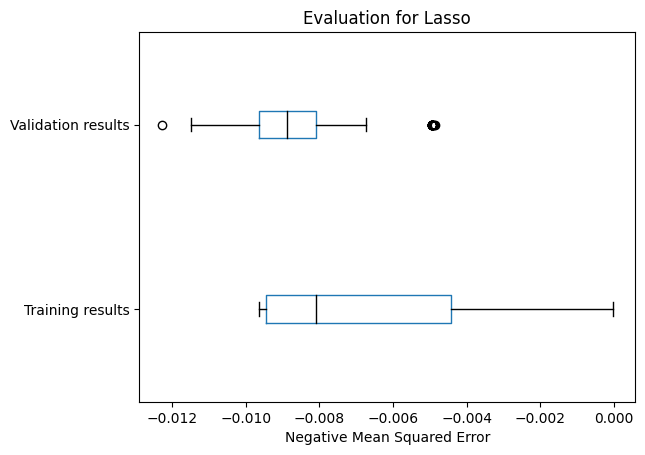

In [ ]:
#concatenate

#training_results_lasso=np.concatenate(training_results_lasso, axis=0)
#validation_results_lasso=np.concatenate(validation_results_lasso, axis=0)

#create dataframe
all_scores_lasso = {
    "Training results": training_results_lasso,
    "Validation results": validation_results_lasso,
}
all_scores_lasso = pd.DataFrame(all_scores_lasso)

#visualize

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores_lasso.plot.box(color=color, vert=False)
plt.xlabel("Negative Mean Squared Error")
_ = plt.title("Evaluation for Lasso")

#Training and "validation"
print("The mean of the standard deviations in training negative mean squared errors scores computed during CV iterations is:", np.mean(training_results_sd_lasso ))
print("The mean of the standard deviations in test negative mean squared errors computed during CV iterations is:", np.mean(validation_results_sd_lasso))

Next, ElasticNet was tested

In [ ]:
#Elastic net

X=ccle.iloc[:,:-2]
y=ccle['target']

#convert from numpy to pandas
X= pd.DataFrame(X)
#y=pd.DataFrame(y)

my_seed = 490
scorers = 'neg_mean_squared_error'
model = ElasticNet()
outer_splits =10
inner_splits = 3

# creating a dictionary containing potential values of parameters
params = {'alpha':[0.00005,0.0005,0.001, 0.01, 0.05, 0.06, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100],
        'l1_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1],
        'tol': [1e-2]}
# configure the cross-validation procedure
cv_outer = KFold(n_splits=outer_splits, shuffle=True, random_state=my_seed)
# enumerate splits
test_results_en = list()
training_results_en = list()
training_results_sd_en = list()
validation_results_en=list()
validation_results_sd_en= list()
for train_ix, test_ix in cv_outer.split(X,y):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    for column in X_train: 
        X_train[column] = X_train[column].fillna(X_train[column].median()) 
    for columni in X_test:
        X_test[columni] = X_test[columni].fillna(X_test[columni].median()) 
    #scaling
    scaler = StandardScaler()
    scaler.fit(X_train)  # fit only on training data
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)  # apply same transformation to test data
    # configure the inner cross-validation startegy
    cv_inner = KFold(n_splits=inner_splits, shuffle=True, random_state=my_seed)
    # define search
    search = GridSearchCV(model, params, scoring=scorers, cv=cv_inner, return_train_score=True)
    # execute search
    result = search.fit(X_train, y_train)
    # Obtain scores
    train_scores_mean = (search.cv_results_['mean_train_score']) 
    train_scores_sd = (search.cv_results_['std_train_score'])
    validation_scores_mean = (search.cv_results_['mean_test_score']) 
    validation_scores_sd = (search.cv_results_['std_test_score'])
    # predict on test set
    best_model_en= result.best_estimator_
    yhat = best_model_en.predict(X_test) 
    # evaluate the model.            
    test_score = mean_squared_error(y.iloc[test_ix], yhat)
    # store the results
    training_results_en.append(train_scores_mean)
    training_results_sd_en.append(train_scores_sd)
    validation_results_en.append(validation_scores_mean)
    validation_results_sd_en.append(validation_scores_sd)
    test_results_en.append(test_score)
    
#Print the best score and parameters
print(result.best_score_)
print(result.best_params_)




  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/135761110.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/135761110.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/135761110.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [ ]:
#External test set
X_gdsc=gdsc.iloc[:,:-2]
y_gdsc= gdsc['target']

#fit the best model to external test set
X_gdsc=StandardScaler().fit_transform(X_gdsc)

#prediction
yhat_en = best_model_en.predict(X_gdsc) 

#evaluation
gdsc_results_en= mean_squared_error(y_gdsc, yhat_en) 

The mean of the standard deviations in training negative mean squared errors computed during CV iterations is: 0.001316155477548996
The mean of the standard deviations in test negative mean squared errors computed during CV iterations is: 0.0035186036174725513


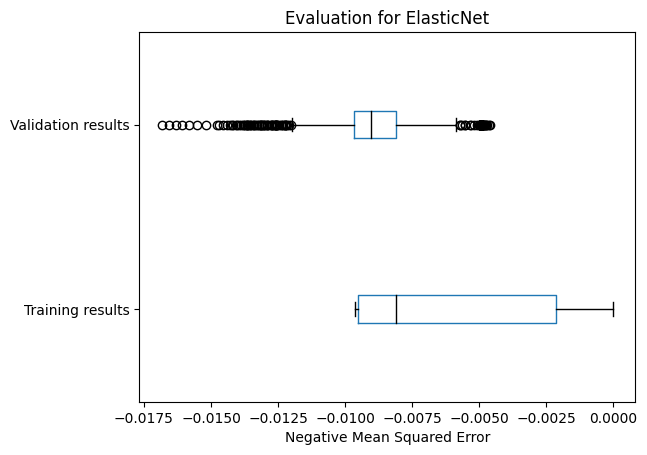

In [ ]:
#concatenate lists of arrays

#training_results_en=np.concatenate(training_results_en, axis=0)
#validation_results_en=np.concatenate(validation_results_en, axis=0)

#create dataframe
all_scores_en = {
    "Training results": training_results_en,
    "Validation results": validation_results_en,
}
all_scores_en = pd.DataFrame(all_scores_en)

#visualize

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores_en.plot.box(color=color, vert=False)
plt.xlabel("Negative Mean Squared Error")
_ = plt.title("Evaluation for ElasticNet")

print("The mean of the standard deviations in training negative mean squared errors computed during CV iterations is:", np.mean(training_results_sd_en ))
print("The mean of the standard deviations in test negative mean squared errors computed during CV iterations is:", np.mean(validation_results_sd_en))

Lastly, Linear regression is used. 

In [ ]:
#Linear regression

X=ccle.iloc[:,:-2]
y=ccle['target']

#convert from numpy to pandas
X= pd.DataFrame(X)
#y=pd.DataFrame(y)

my_seed = 5
scorers = 'neg_mean_squared_error'
model = LinearRegression()
outer_splits =10
inner_splits = 3

# creating a dictionary containing potential values of parameters
params = {'fit_intercept':["True", "False"]}
# configure the cross-validation procedure
cv_outer = KFold(n_splits=outer_splits, shuffle=True, random_state=my_seed)
# enumerate splits
test_results_lr = list()
training_results_lr = list()
training_results_sd_lr = list()
validation_results_lr=list()
validation_results_sd_lr= list()
for train_ix, test_ix in cv_outer.split(X,y):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    for column in X_train: 
        X_train[column] = X_train[column].fillna(X_train[column].median()) 
    for columni in X_test:
        X_test[columni] = X_test[columni].fillna(X_test[columni].median()) 
    #scaling
    scaler = StandardScaler()
    scaler.fit(X_train)  # fit only on training data
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)  # apply same transformation to test data
    # configure the inner cross-validation startegy
    cv_inner = KFold(n_splits=inner_splits, shuffle=True, random_state=my_seed)
    # define search
    search = GridSearchCV(model, params, scoring=scorers, cv=cv_inner, return_train_score=True)
    # execute search
    result = search.fit(X_train, y_train)
    # Obtain scores
    train_scores_mean = (search.cv_results_['mean_train_score']) 
    train_scores_sd = (search.cv_results_['std_train_score'])
    validation_scores_mean = (search.cv_results_['mean_test_score']) 
    validation_scores_sd = (search.cv_results_['std_test_score'])
    # predict on test set
    best_model_lr= result.best_estimator_
    yhat = best_model_lr.predict(X_test) 
    # evaluate the model.            
    test_score = mean_squared_error(y.iloc[test_ix], yhat)
    # store the results
    training_results_lr.append(train_scores_mean)
    training_results_sd_lr.append(train_scores_sd)
    validation_results_lr.append(validation_scores_mean)
    validation_results_sd_lr.append(validation_scores_sd)
    test_results_lr.append(test_score)
    
#Print the best score and parameters
print(result.best_score_)
print(result.best_params_)


  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/1970359729.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/1970359729.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[columni] = X_test[columni].fillna(X_test[columni].median())
/tmp/ipykernel_242/1970359729.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [ ]:
#External test set
X_gdsc=gdsc.iloc[:,:-2]
y_gdsc= gdsc['target']

#fit the best model to external test set
X_gdsc=StandardScaler().fit_transform(X_gdsc)

#prediction
yhat_lr = best_model_lr.predict(X_gdsc) 

#evaluation
gdsc_results_lr= mean_squared_error(y_gdsc, yhat_lr) 

The mean of the standard deviations in training negative mean squared errors computed during CV iterations is: 1.1196993009941698e-31
The mean of the standard deviations in test negative mean squared errors computed during CV iterations is: 0.0021733107963165217


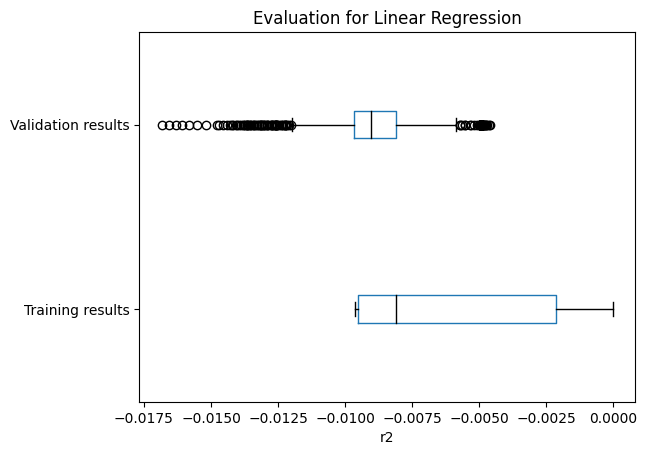

In [ ]:
#concatenate lists of arrays

#training_results_lr=np.concatenate(training_results_lr, axis=0)
#validation_results_lr=np.concatenate(validation_results_lr, axis=0)

#create dataframe
all_scores_lr = {
    "Training results": training_results_lr,
    "Validation results": validation_results_lr,
}
all_scores_lr = pd.DataFrame(all_scores_lr)

#visualize

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores_en.plot.box(color=color, vert=False)
plt.xlabel("r2")
_ = plt.title("Evaluation for Linear Regression")

print("The mean of the standard deviations in training negative mean squared errors computed during CV iterations is:", np.mean(training_results_sd_lr ))
print("The mean of the standard deviations in test negative mean squared errors computed during CV iterations is:", np.mean(validation_results_sd_lr))

In [ ]:
#Combining results of Lasso and ElastiNet

df4=(all_scores_lasso)
df5=(all_scores_en)
df6=(all_scores_lr)

all_scores_reg= pd.concat([df4, df5, df6], axis=1) 

all_scores_reg.columns =["Training Lasso", "Validation Lasso", "Training ElasticNet", "Validation ElasticNet", "Training Linear Regression", "Valdiation Linear Regression"]

all_scores_reg

Training Lasso  Validation Lasso  Training ElasticNet  \
0          -0.000023         -0.010395            -0.000024   
1          -0.000443         -0.006821            -0.000024   
2          -0.002671         -0.007494            -0.000025   
3          -0.004199         -0.007971            -0.000025   
4          -0.005615         -0.008628            -0.000024   
...              ...               ...                  ...   
1435             NaN               NaN            -0.009592   
1436             NaN               NaN            -0.009592   
1437             NaN               NaN            -0.009592   
1438             NaN               NaN            -0.009592   
1439             NaN               NaN            -0.009592   

      Validation ElasticNet  Training Linear Regression  \
0                 -0.013739               -5.877885e-32   
1                 -0.013560               -5.877885e-32   
2                 -0.013400               -1.718910e-31   
3                 -0.013311               -1.718910e-31   
4                 -0.013215               -5.563757e-32   
...                     ...                         ...   
1435              -0.009652                         NaN   
1436              -0.009652                         NaN   
1437              -0.009652                         NaN   
1438              -0.009652                         NaN   
1439              -0.009652                         NaN   

      Valdiation Linear Regression  
0                        -0.009646  
1                        -0.009646  
2                        -0.012645  
3                        -0.012645  
4                        -0.010416  
...                            ...  
1435                           NaN  
1436                           NaN  
1437                           NaN  
1438                           NaN  
1439                           NaN  

[1440 rows x 6 columns]

### 4.4 Analysis of all regressors 

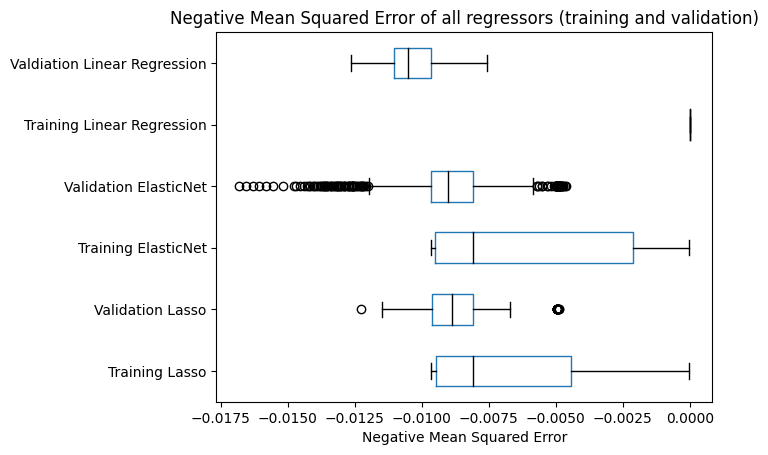

In [ ]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores_reg.plot.box(color=color, vert=False)
plt.xlabel("Negative Mean Squared Error")
_ = plt.title("Negative Mean Squared Error of all regressors (training and validation)")

Negated Mean Squared Error is offered as evaluation metric by grid search, so in this boxplot it is used to compare validation and training scores (divided from original training set) for all used classifiers.  In sklearn all scorer objects follow the practise that higher return values are better than lower return values. This is why metrics which measure the distance between the model and the data, like metrics.mean_squared_error, are available as neg_mean_squared_error which return the negated value of the metric. Hence, in this boxplot higher values are better. We can clearly observe that linear regression has values around 0 within training set, but severely smaller values within validation set, which indicates severe overfitting. Performance of Lasso and ElasticNet seems to be quite similar. 

In [ ]:
lasso_train_mean=np.mean(training_results_lasso)
lasso_test_mean=np.mean(test_results_lasso)
lasso_gdsc_mean=np.mean(gdsc_results_lasso)
en_train_mean=np.mean(training_results_en)
en_test_mean=np.mean(test_results_en)
en_gdsc_mean=np.mean(gdsc_results_en)
lr_train_mean=np.mean(training_results_lr)
lr_test_mean=np.mean(test_results_lr)
lr_gdsc_mean=np.mean(gdsc_results_lr)

train_reg_mean= abs(lasso_train_mean), abs(en_train_mean), abs(lr_train_mean) #negative values turned to positive
test_reg_mean = lasso_test_mean, en_test_mean, lr_test_mean
gdsc_reg_mean = lasso_gdsc_mean, en_gdsc_mean, lr_gdsc_mean
#train_cl_f1_means = 
#test_cl_f1_means = 
#GDSC_cl_f1_means = 

data_eval_reg = pd.DataFrame({'model':["Lasso","ElasticNet","Linear Regression"],
                             'train_mse': train_reg_mean,
                             'test_mse': test_reg_mean,
                             'gdsc_mse': gdsc_reg_mean})
                             #'train_f1': train_cl_f1_list,
                             #'test_f1': test_cl_f1_list,
                             #'gdsc_f1': GDSC_cl_f1_list})

In [ ]:
data_eval_reg

model     train_mse  test_mse  gdsc_mse
0              Lasso  6.493114e-03  0.006604  0.006782
1         ElasticNet  6.087957e-03  0.006956  0.006751
2  Linear Regression  1.342824e-31  0.037864  0.030034

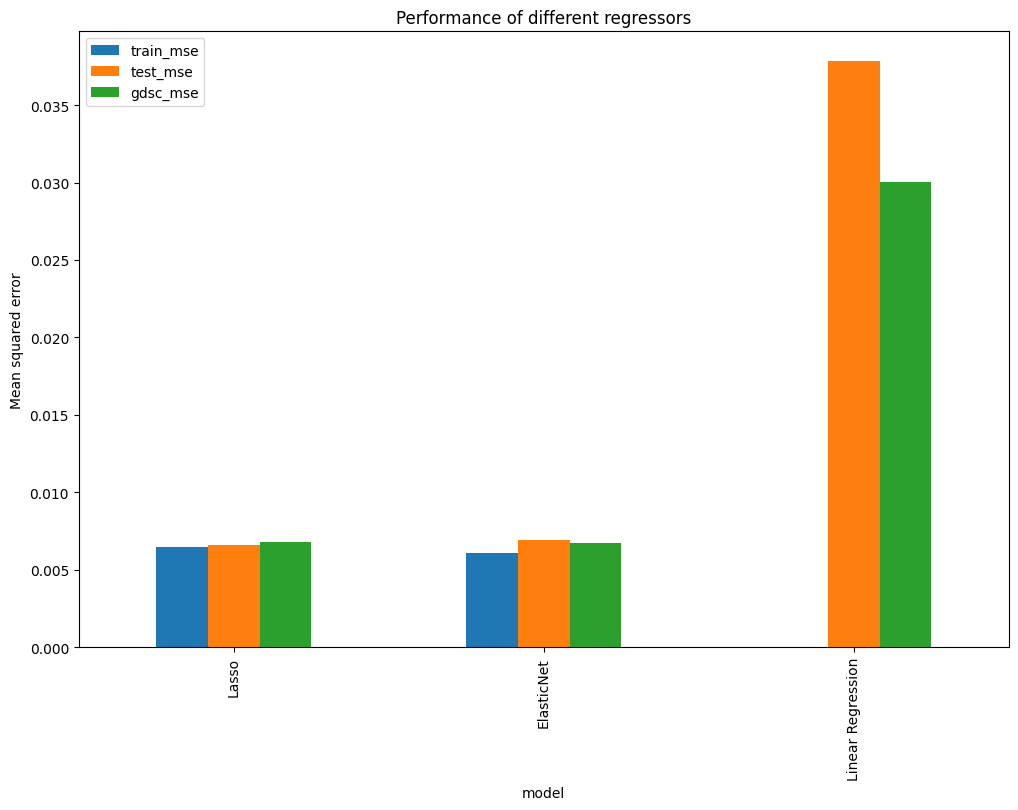

In [ ]:
#Tässä plotissa ei nyt ole niitä "validation" tuloksia.

data_eval_reg.plot(x='model', y=['train_mse','test_mse','gdsc_mse'],
                  kind="bar", figsize=(12,8), title='Performance of different regressors')
plt.ylabel("Mean squared error")
plt.legend(loc='upper left')
plt.show()

According to Géron et al. (2019), Negative Mean Squared Error can be turned into a positive value. Here we have turned Negative Mean Squared Error values recorded from cross validation into positive values, to represent Mean Squared Error (MSE), that was used to evaluate test (CCLE) and external test set (GDSC). 

Boxplot here shows the MSEs for training and test sets (CCLE) and external test set (GDSC) for all tested regressors. When we are evaluating the error, the smaller value is better. Performance of both of the the regularization based models, Lasso and ElasticNet, if fairly good, but linear regression is severely overfitting. In linear regression MSE for training set is extremely low, whereas for test sets results are much worse. 

## 5. Select biomarkers of drug sensitivity <a id="section_5"></a>

From the models we used, Random Forest, Linear Regression, Lasso and ElasticNet have ability to assign weights (importances) to features. These weights describe how useful these features are at predicting target variable. In our project, these important features are the biomarkers (genes)  that we will use to find molecular subgroups from leukemia patient data. 

In [ ]:
#to retrieve the gene names
X2=ccle.iloc[:,:-2]

#Important features for RF
importances_rf = best_model_rf.feature_importances_
importances_rf = pd.Series(importances_rf, index=X2.columns)
importances_rf=importances_rf.sort_values(ascending=False)

#Important features for Lasso
importances_lasso = np.abs(best_model_lasso.coef_)
importances_lasso = pd.Series(importances_lasso, index=X2.columns)
importances_lasso=importances_lasso.sort_values(ascending=False)

#Important features for Linear Regression
importances_lr = np.abs(best_model_lr.coef_)
importances_lr = pd.Series(importances_lr, index=X2.columns)
importances_lr= importances_lr.sort_values(ascending=False)


#Important features for ElasticNet
importances_en = np.abs(best_model_en.coef_)
importances_en = pd.Series(importances_en, index=X2.columns)
importances_en=importances_en.sort_values(ascending=False)

In [ ]:
#Top 10 of the most important features for each model. 
print(importances_rf.head(10))
print(importances_lasso.head(10))
print(importances_en.head(10))
print(importances_lr.head(10))

ENSG00000174579    0.031408
ENSG00000009790    0.020853
ENSG00000213079    0.020256
ENSG00000004864    0.019600
ENSG00000172493    0.019020
ENSG00000078596    0.018640
ENSG00000011600    0.016398
ENSG00000086730    0.016148
ENSG00000169045    0.016085
ENSG00000197747    0.015897
dtype: float64
ENSG00000172232    0.015354
ENSG00000274736    0.013381
ENSG00000164512    0.012158
ENSG00000163563    0.012082
ENSG00000185338    0.010217
ENSG00000004939    0.009643
ENSG00000183134    0.009165
ENSG00000114737    0.009107
ENSG00000135297    0.009106
ENSG00000244734    0.009082
dtype: float64
ENSG00000172232    0.014285
ENSG00000274736    0.012481
ENSG00000164512    0.012022
ENSG00000163563    0.011986
ENSG00000185338    0.010261
ENSG00000004939    0.009545
ENSG00000183134    0.008971
ENSG00000135297    0.008962
ENSG00000114737    0.008876
ENSG00000244734    0.008637
dtype: float64
ENSG00000112799    0.042270
ENSG00000196591    0.037041
ENSG00000100351    0.033302
ENSG00000258227    0.031958
ENS

### 5.1 Compare feature importance using feature weights <a id="section_5.1"></a>


Text(0.5, 1.0, 'Feature importance ElasticNet')

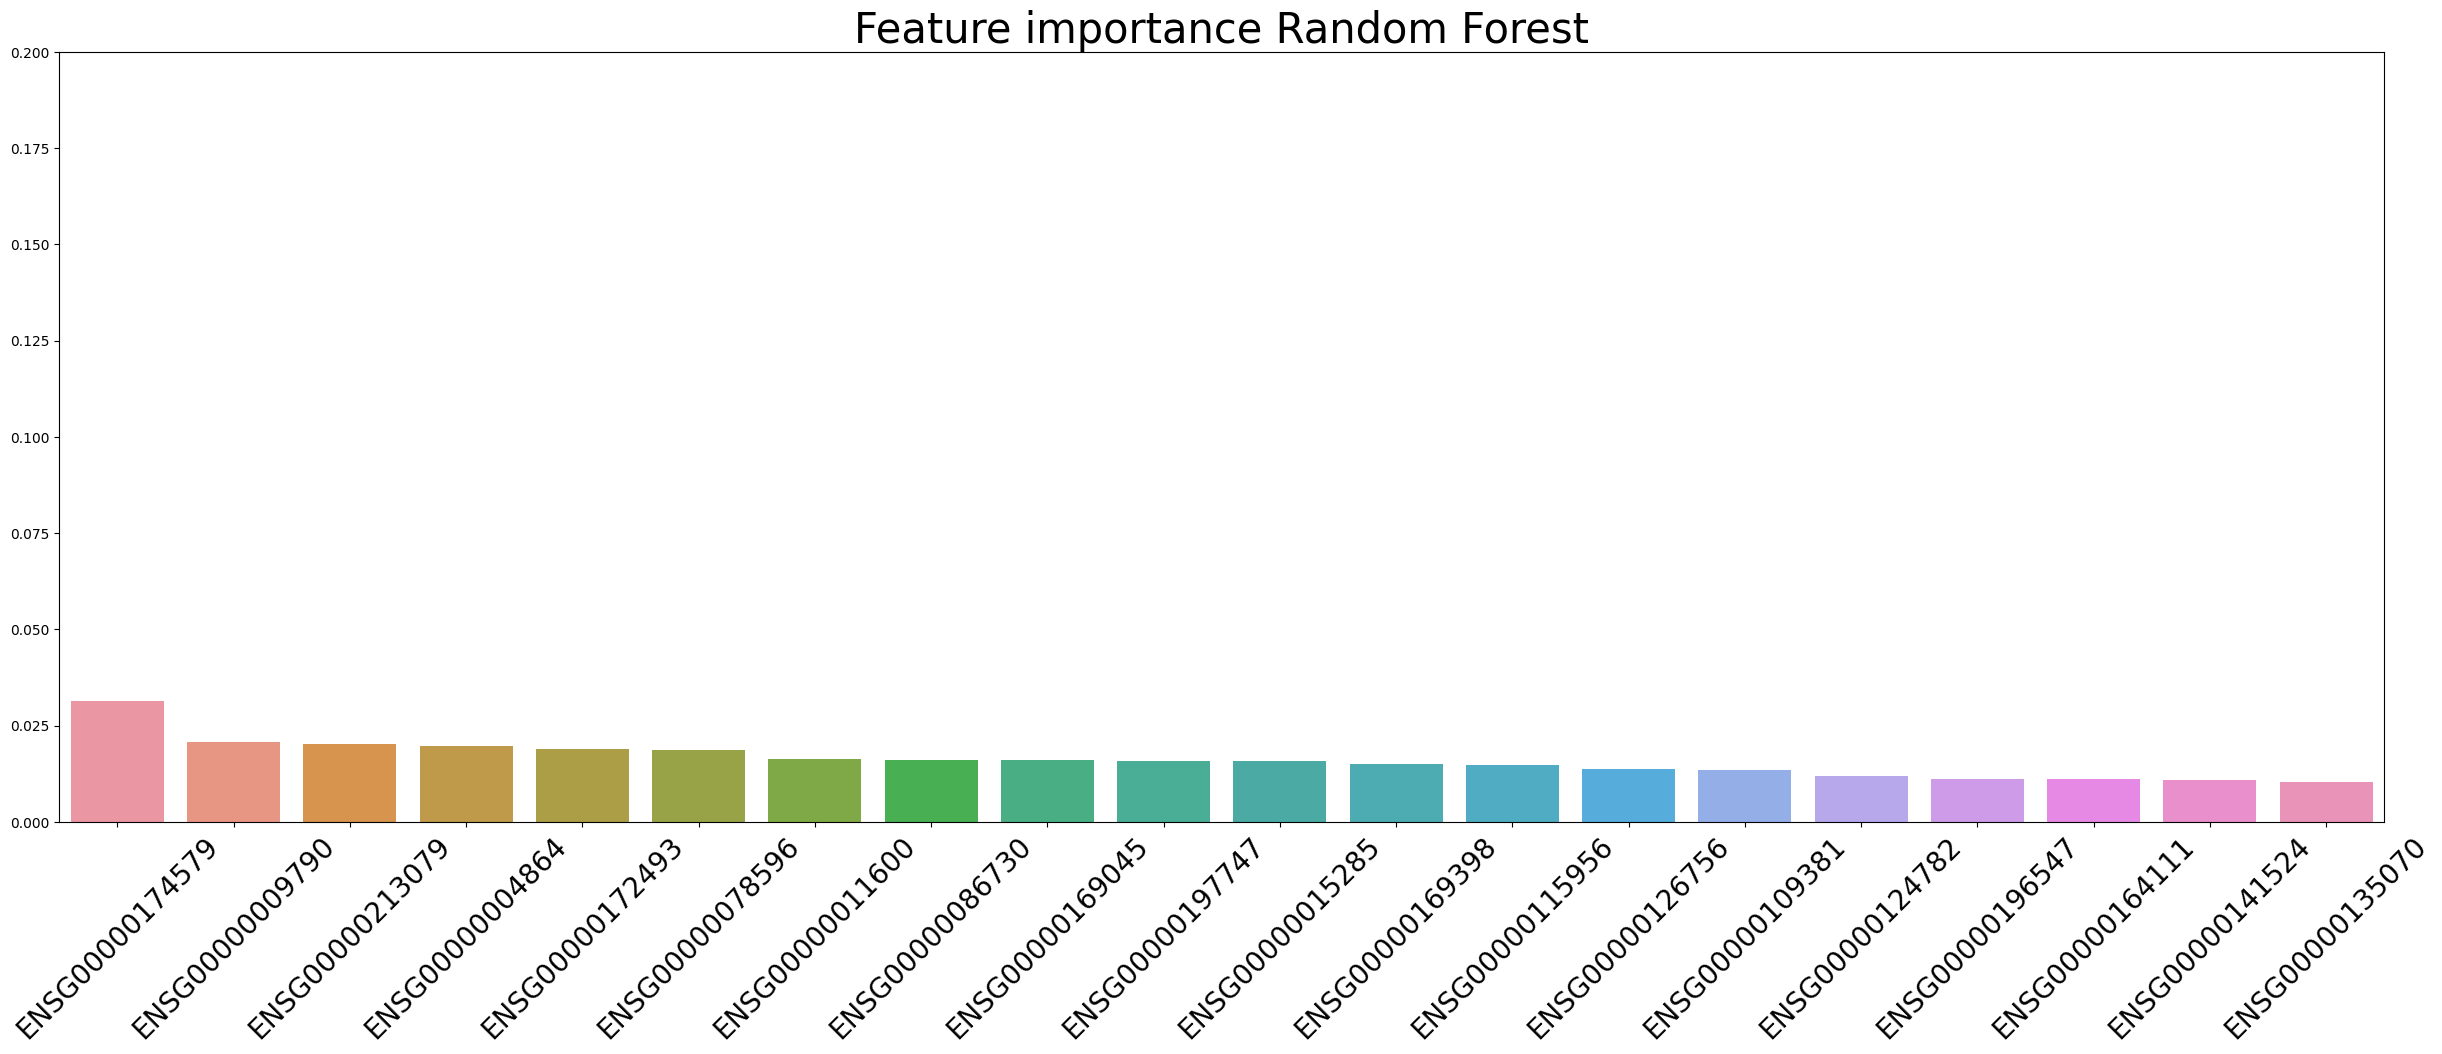

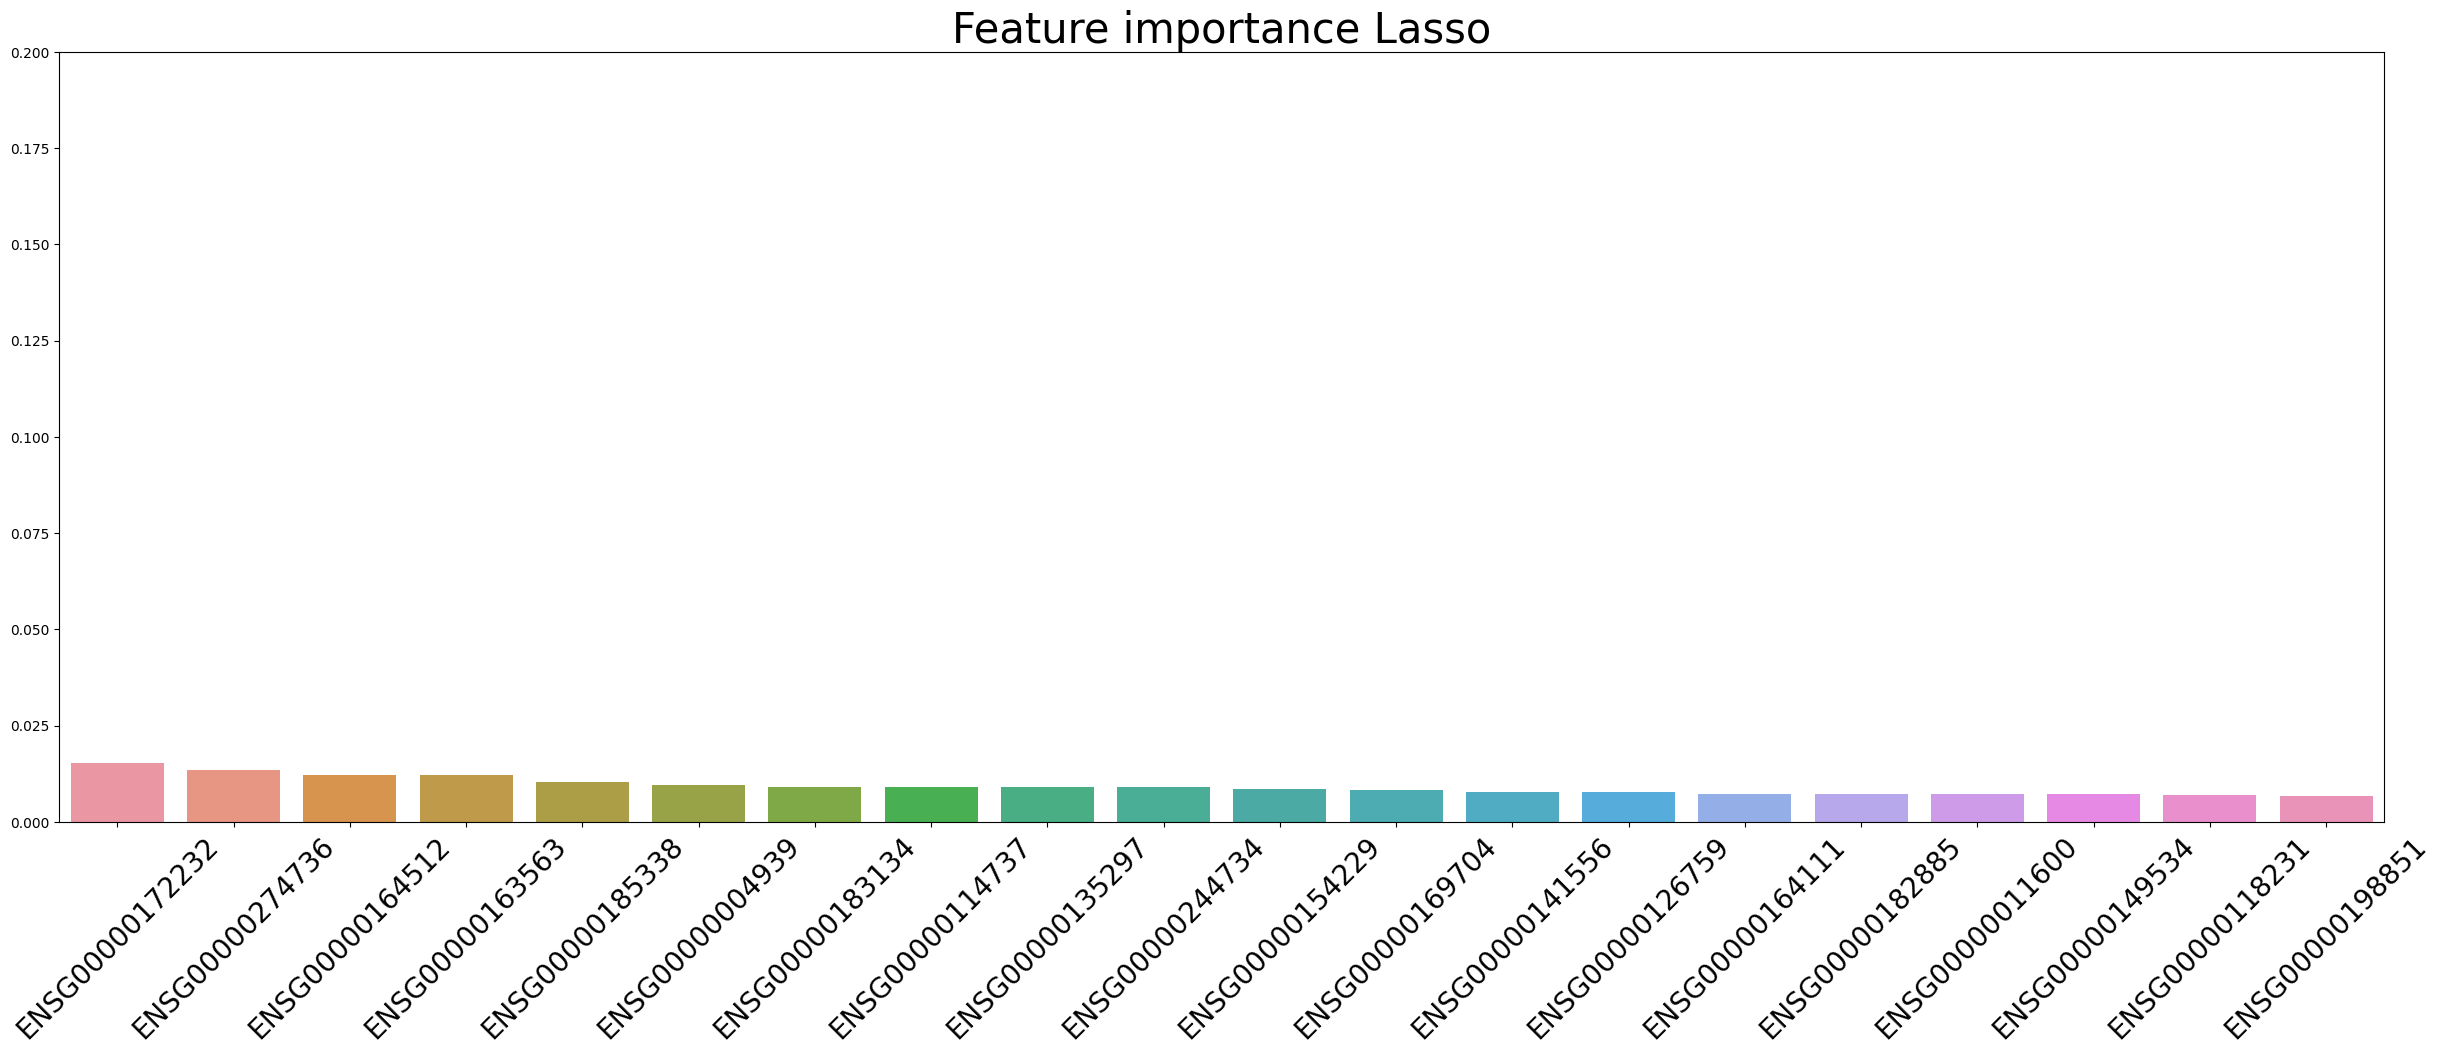

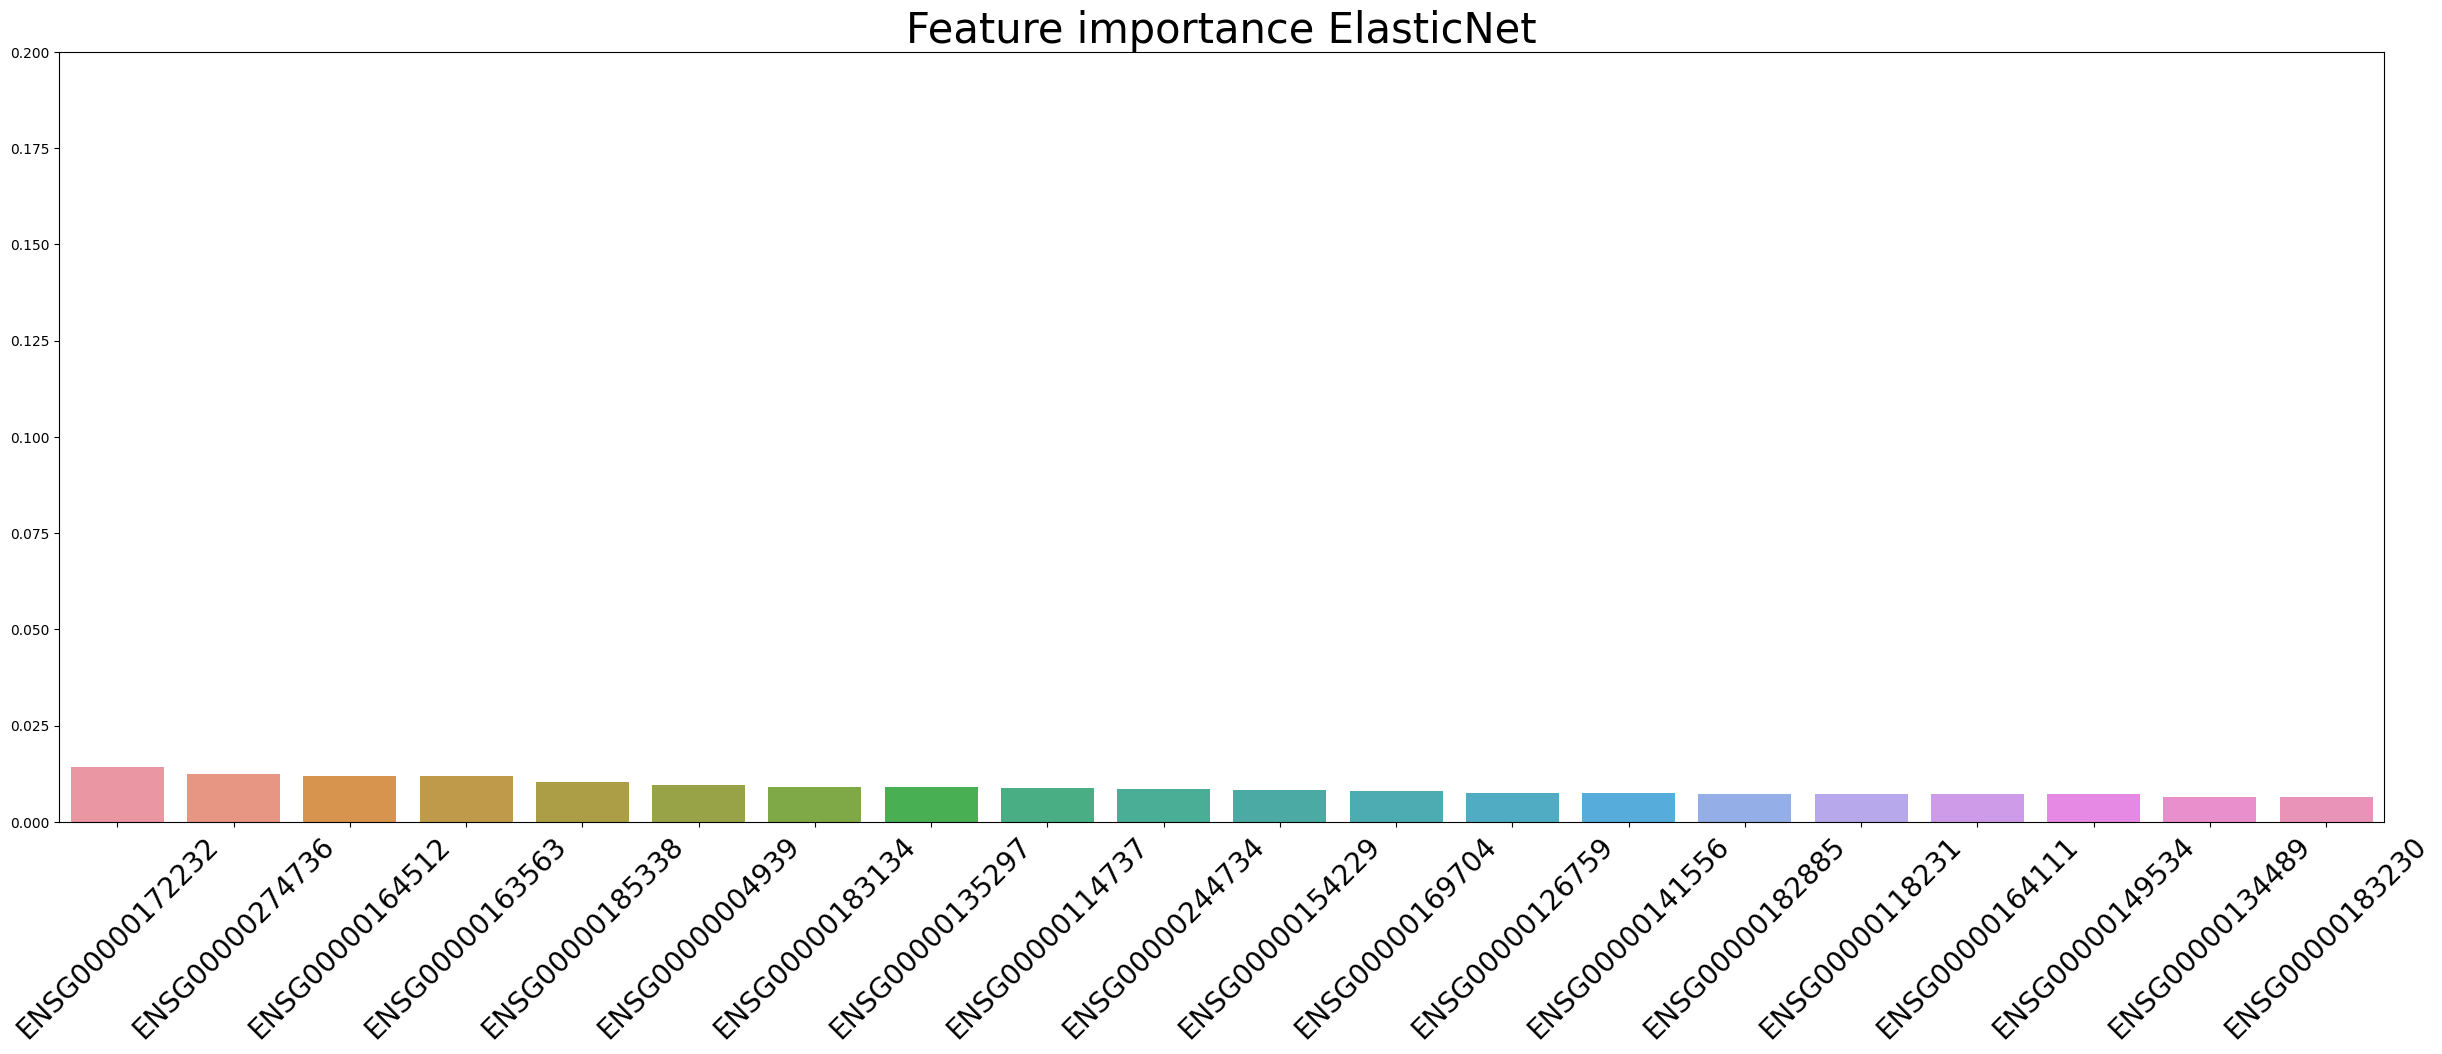

In [ ]:
#Random Forest 
importances_rf=pd.DataFrame(importances_rf)
importances_rf_top=importances_rf[0:20]
importances_rf_top=importances_rf_top.T

plt.figure(figsize=(30,10))
plt.ylim(0,0.2)
a=sns.barplot(data=importances_rf_top)

a.set_xticklabels(a.get_xticklabels(),rotation=45) #rotation
a.tick_params(axis='x', labelsize=20) 
plt.title('Feature importance Random Forest', fontsize = 30)


#Lasso
importances_lasso=pd.DataFrame(importances_lasso)
importances_lasso_top=importances_lasso[0:20]
importances_lasso_top=importances_lasso_top.T

plt.figure(figsize=(30,10))
plt.ylim(0,0.2)
b=sns.barplot(data=importances_lasso_top)

b.set_xticklabels(b.get_xticklabels(),rotation=45) #rotation
b.tick_params(axis='x', labelsize=20) 
plt.title('Feature importance Lasso', fontsize = 30)

#ElasticNet
importances_en=pd.DataFrame(importances_en)
importances_en_top=importances_en[0:20]
importances_en_top=importances_en_top.T

plt.figure(figsize=(30,10))
plt.ylim(0,0.2)
c=sns.barplot(data=importances_en_top)

c.set_xticklabels(c.get_xticklabels(),rotation=45) #rotation
c.tick_params(axis='x', labelsize=20) 
plt.title('Feature importance ElasticNet', fontsize = 30)



From these figures we can see, that ElasticNet and Lasso share many features. Moreover, Random Forest have 2 common genes with Lasso and ElasticNet. Weights are not very different, which means that none of these genes are very important at predicting target variable. However, results are promising since we were able to find similar genes by using different models. 

Text(0.5, 1.0, 'Feature importance Linear Regression')

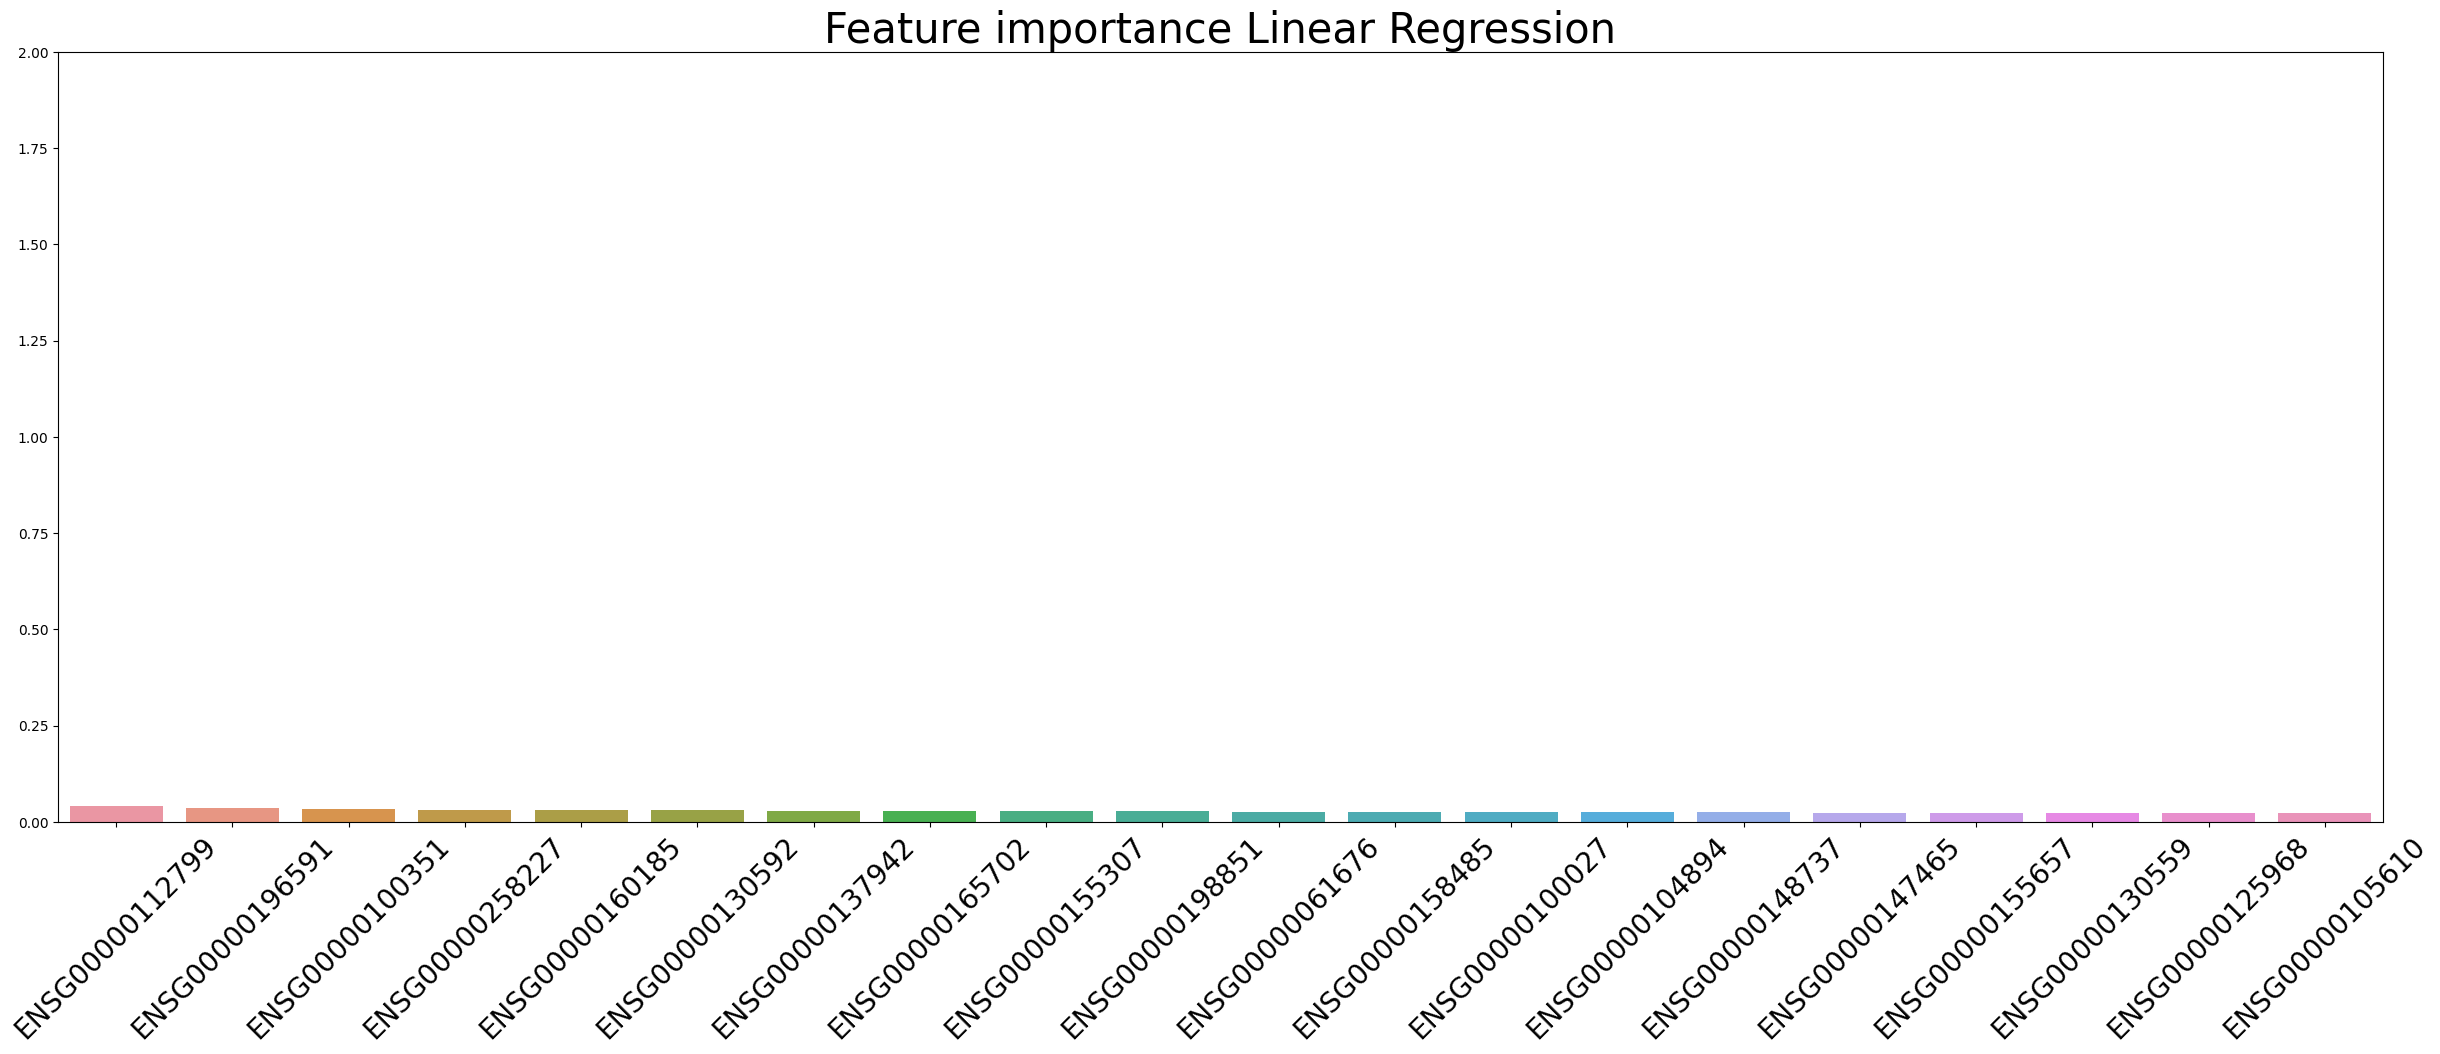

In [ ]:
#Tää on sen takia eri solussa, kun skaala on ihan eri. 

#Linear Regression
importances_lr=pd.DataFrame(importances_lr)
importances_lr_top=importances_lr[0:20]
importances_lr_top=importances_lr_top.T

plt.figure(figsize=(30,10))
plt.ylim(0,2)
d=sns.barplot(data=importances_lr_top)

d.set_xticklabels(d.get_xticklabels(),rotation=45) #rotation
d.tick_params(axis='x', labelsize=20) 
plt.title('Feature importance Linear Regression', fontsize = 30)

This plot represents important features identified by Linear Regression. Results are weak, which was expected based on model's weak performance earlier. Genes identified by Linear Regression model are very different from other models and there are not much differences between the features. 

### 5.2 Feature importance in literature  <a id="section_5.2"></a>

Use the GeneCards database (https://www.genecards.org/) to shortly describe the selected genes and convert them to gene symbols.

Genes: 

#ENSG00000011600 = TYROBP is a tyrosine kinase, which is typically heavily upregulated in leukemia. It is an oncogene. (Liao et al. 2015)

#ENSG00000164111 = Anxa2 is calcium-dependent phospholipid-binding protein which is expressed in  tumor cells. It plays important roles in membrane formation and transportation, exocytosis, cell proliferation, signal transduction, cell differentiation and apoptosis . Anxa2 was found deregulated in many cancers, such as acute promyelocytic leukemia (Zhang et al. 2012). ANXA2 expression has been linked to sensitivity in cancer treatment.

#ENSG00000174579 = MSL2 is tumor supressor gene and a p53 ligase that promotes ubiquitin-dependent cytoplasmic p53 localization. It is highly expressed in AML (Byers et al. 2011) and in some cases predicts unfavourable outcome for patiens.

#ENSG00000172232 = AZU1 is gene associated in inflamation. It is a member of the serine protease gene family but it is not a serine proteinase, because the active site serine and histidine residues are replaced. It is often expressed in leukemia and indicates a positive response to chemotherapy (Jiang et al. 2020).

#ENSG00000274736 = CCL23 (C-C Motif Chemokine Ligand 23) belongs to superfamily of chemokines, that are associated with immunoregulatory and inflammatory processes (GeneCards). Studies have provided evidence that CCL23 is over expressed in many patients with AML and could be used as prognostic biomarker in AML, and is related to poor prognosis (Wang et al. 2022). 

#ENSG00000164512 = The function of ANKRD55 (Ankyrin Repeat Domain 55) is unclear, but mutations in this gene has been associated with autoimmune diseases. Ankyrin repeat domains are one of the most common basis of protein-protein interactions, which indicates that ANKRD55 might function in complex with other proteins (Ugidos et al. 2019). 

#ENSG00000163563 = MNDA (Myeloid Cell Nuclear Differentiation Antigen) is specifically expressed in cells of granulocyte-monocyte (myeloid) lineage (GeneCards). It promotes degradation of the anti-apoptotic factors and apoptosis in myeloid cells under stress conditions. For example in chronic lymphatic leukemia, higher expression of MNDA is associated with better outcome (Bottardi et al. 2020). 

ENSG00000185338 = 	SOCS1 (Suppressor Of Cytokine Signaling 1) encodes a member of Suppressor of Cytokine Signaling (SOCS) family, members of which are negative regulators of cytokine signaling (GeneCards). SOCS1 is shown to have tumor suppressor activity. The proliferation and differentiation of hematopoietic precursor cells is dependent from various cytokines, and alterations in SOCS1 gene expression is linked to acute myeloid leukemia (Hou et al. 2017). 

## 6. Clustering mRNA profiles of cancer patients  <a id="section_6"></a>

Use clustering approaches to divide cancer patients (within a specific cancer type) into molecular subgroups based on the transcriptomic profile of gene-based biomarkers that were selected for drug sensitivity prediction. 


We have different gene annotations, need to compare ensemble to gene symbols! Only few genes (10 or less) selected, so this can be done manually. Genecard or something similar could be used.

In this section we are focusing on the second objective our project, which was to classify leukemia patients into molecular subgroups based on identified biomarkers using unsupervised learning. Thus far we have identified important genes that models use to distinguish between high and low sensitivity cell lines. Next interesting topic is trying to identify, if we can detect distinguished subgroups from the patient data based on expression of these genes. 

In [ ]:
#concat all the dataframes based on common genes and see how many of them are the same. 
#importances_lasso_top
#importances_en_top
importances_rf_ls = np.intersect1d(importances_rf_top.columns, importances_lasso_top.columns)
importances_ls_en = np.intersect1d(importances_lasso_top.columns, importances_en_top.columns)
#print("common with lasso and rf:", importances_rf_ls)
#print("common with lasso and en:", importances_ls_en)
np.isin(importances_rf_ls, importances_ls_en) 
print(importances_rf_ls)


['ENSG00000011600' 'ENSG00000164111']


In [ ]:
#These are common between all
ENSG00000011600    #common in all 
ENSG000000164111    #common in all
ENSG00000174579   #top gene for RF
#This is the top 6 of Lasso and ElasticNet
ENSG00000172232    
ENSG00000274736    
ENSG00000164512    
ENSG00000163563    
ENSG00000185338 

In [10]:
CCLE_gene_names=["ENSG00000011600", "ENSG00000011600", "ENSG00000174579", "ENSG00000172232"    ,"ENSG00000274736",    "ENSG00000164512", "ENSG00000163563", "ENSG00000185338"]


Let's check the gene names from bioinformatics database, such as ensembl

In [11]:
listOfGenes=['TYROBP', 'ANXA5', 'MSL2', 'AZU1', 'CCL23', 'ANKRD55', 'MNDA', 'SOCS1']


In [12]:

#TCGA patient data. Let's use the first col with patient indexes as index for this dataframe
tcga=pd.read_csv("leukemia_mrna.csv", sep=',', index_col="Unnamed: 0")
tcga.head()


A1BG  A1CF  A2BP1    A2LD1   A2ML1       A2M    A4GALT  \
TCGA-AB-2803  412.4280   0.0    0.0  71.4095  2.0576  467.0782   11.3169   
TCGA-AB-2805   84.7724   0.0    0.0  48.5475  3.3467   16.0643    0.6693   
TCGA-AB-2806  187.1483   0.0    0.0  50.8339  5.7288    7.0019   17.8230   
TCGA-AB-2807  346.4449   0.0    0.0  45.7498  0.9930  343.5948  116.1867   
TCGA-AB-2808  131.7203   0.0    0.0  47.1328  5.4988  255.9152  182.2467   

               A4GNT  AAA1      AAAS  ...      ZXDA      ZXDB       ZXDC  \
TCGA-AB-2803  0.0000   0.0  514.4033  ...   32.9218  451.6461  3404.3210   
TCGA-AB-2805  2.6774   0.0  532.7979  ...   12.0482  356.0910  4020.0803   
TCGA-AB-2806  1.2731   0.0  504.1375  ...   67.4729  825.5888  3817.3138   
TCGA-AB-2807  4.9652   0.0  697.1202  ...  151.9364  910.6256  2579.9404   
TCGA-AB-2808  0.7855   0.0  443.8335  ...   40.0628  506.6771  3084.8390   

               ZYG11A     ZYG11B        ZYX      ZZEF1       ZZZ3  psiTPTE22  \
TCGA-AB-2803  15.4321  1108.0247  4480.4527  2488.6831  1199.5885    16.4609   
TCGA-AB-2805   2.6774  1774.4311  5780.4552  3826.6399  1145.9170    12.0482   
TCGA-AB-2806   1.9096   749.2043  5467.8549  3679.8218  1944.6213    97.3902   
TCGA-AB-2807   4.9652  1206.5541  3543.1976  4209.5333  1394.2403    17.8749   
TCGA-AB-2808   1.5711  1582.0896  3626.8657  2891.5947  1432.0503    21.9953   

                tAKR  
TCGA-AB-2803  0.0000  
TCGA-AB-2805  5.3548  
TCGA-AB-2806  0.0000  
TCGA-AB-2807  6.9513  
TCGA-AB-2808  0.0000  

[5 rows x 20501 columns]

It would appear, that our best 8 genes are annotated in a different manner to this dataframe, therefore, we have to find out what gene correseponds to what. 

In [13]:
#Genes can be stored with different names. Let's see if we can find the selected biomarkers from 
#the TCGA data. 
for x in listOfGenes:
    if x in tcga.columns:
        print(x, "Yes")
    else:
        print(x, "No") 
print(listOfGenes)

TYROBP Yes
ANXA5 Yes
MSL2 Yes
AZU1 Yes
CCL23 Yes
ANKRD55 Yes
MNDA Yes
SOCS1 Yes
['TYROBP', 'ANXA5', 'MSL2', 'AZU1', 'CCL23', 'ANKRD55', 'MNDA', 'SOCS1']


All the genes are found

A new dataframe has to be made with only the selected genes. 

In [14]:
#select only the eight genes from the cancer patient data. 
genes=tcga[listOfGenes].copy()
genes.shape

(173, 8)

PCA is good way to visualize the data and to get a preliminary idea of clusters. 

In [15]:
from sklearn.preprocessing import StandardScaler # Always scale data for good results on PCA
scaler = StandardScaler()
geneScaled=scaler.fit_transform(genes)


<AxesSubplot: ylabel='Density'>

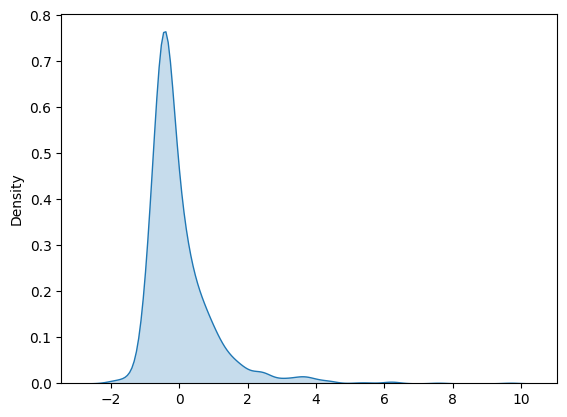

In [ ]:
#visualize the density of the whole dataset

flatten_scaled = geneScaled.flatten()

#density plot from whole data
import seaborn as sb 


sb.kdeplot(flatten_scaled, fill = True)


We have already seen that these genes could be important for drug response in leukemia. However, we can further support the selection of these genes and check for redundancy

In [ ]:
#import the package and do the PCA
from sklearn.decomposition import PCA
pca_sc = PCA(n_components=0.95) # we can specify the number of components OR the desired minimum explained variance
x_pca = pca_sc.fit_transform(geneScaled)
print(x_pca.shape)
print(pca_sc.explained_variance_ratio_) 
print(pca_sc.explained_variance_ratio_.sum())
loadings = pca_sc.components_

(173, 7)
[0.34280196 0.1463451  0.14466123 0.1303229  0.09091839 0.0672468
 0.04836134]
0.9706577277244953


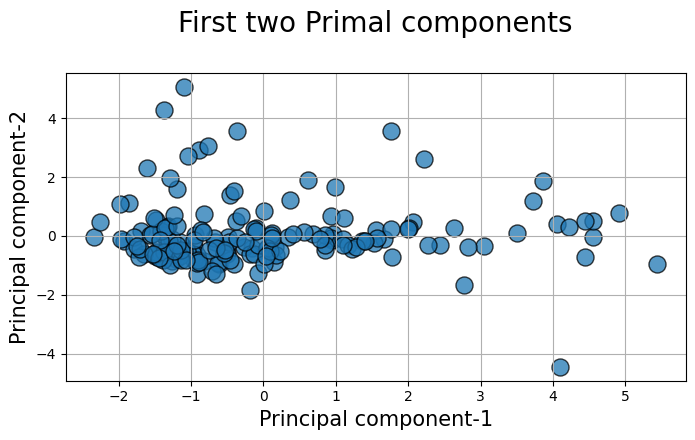

In [ ]:
#plot the results
plt.figure(figsize=(8,4))
plt.scatter(x_pca[:,0], x_pca[:,1], c=None, edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
plt.title("First two Primal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

Here we see that 7 principal components are required for explaining 95% data. Remember that we have eight dimensions in the data. Therefore PCA doesn't provide us with anything magnificent. This makes plotting the data in a meaningful way difficult. The first two component only cover roughy 50% of the variance.

<AxesSubplot: >

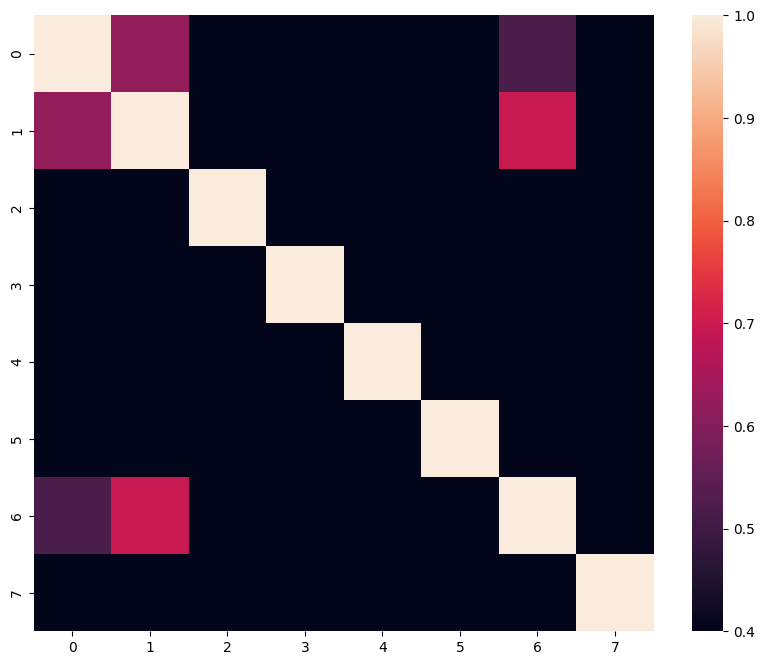

In [ ]:
#check if the features correlate
cor=np.corrcoef(geneScaled.T)
plt.figure(figsize=(10, 8))
axis_labels = listOfGenes
sns.heatmap(cor, vmin=0.4, vmax=1, cmap=None) 


There seems to be very little correlation between the genes. Therefore, we don't have to take any measures to deal with colinnearity.

Let us do first clustering with Kmeans. Kmeans algorithm is relatively straightforward and converges to a local optimum quickly. Starting point in Kmeans algorithm may influence the performance, so let us do 100 different starting points and compare the silhoette scores. For each starting point, 2-10 clusters are formed.

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
# create a k-means object
#sse = []
clusters=[]
for i in range(0,100):
    #klusterit=1
    coeff=[]
    for x in range(2,11):  
        kmeans = KMeans(n_clusters=x, random_state=i)  
        kmeans.fit(geneScaled)  
        #print('\nCluster centres:') 
        #print(kmeans.cluster_centers_)
        #sse.append(kmeans.inertia_)
        #klusterit+=1
        #print('number of clusters', klusterit, ':', silhouette_score(geneScaled, kmeans.labels_))
        coeff.append(silhouette_score(geneScaled, kmeans.labels_))
    maxim=max(coeff)
    #print("best silhoette score", maxim, "number of cluster:", (coeff.index(maxim)+2))
    #add the number of clusters in the list. add 2 to match the index. 
    clusters.append(coeff.index(maxim)+2)


In [ ]:
from collections import Counter
Counter(clusters)


Counter({3: 61, 4: 17, 6: 1, 2: 20, 5: 1})

It would seem that three clusters gives the best silhouette scores in almost two thirds of the initial starting points. Therefore, three clusters is most likely the best choice going forward.

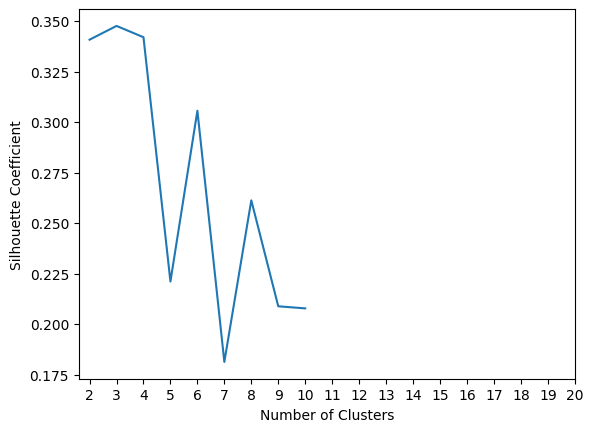

In [ ]:
#plot one of the staring points. 
plt.plot(range(2, 11), coeff)
plt.xticks(range(2, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

DBSCAN offers many advantages to the inferior Kmeans algorithm, that we will not be going in-depth. One of the advantages is that the number of clusters needs not to be define beforehand. The algorithm itself defines how many is the optimal number. 

For us to see the results, let's use the PCA data from the scaled genes.

In [ ]:
#for the code to work, a dataframe has to be inserted, geneScaled is an array. 
df345=pd.DataFrame(data=x_pca, index=None, columns=None)


In [ ]:
#let's select the combination of min_samples and epsilon with two for-loops and save the results
output = []
for ms in range(2,6):
    for ep in range(1, 5):
        labels = DBSCAN(min_samples=ms, eps = ep).fit(df345).labels_
        score = silhouette_score(df345, labels)
        output.append((ms, ep, score))

Best silhouette_score: 0.08446890078448319
min_samples: 2
eps: 1
Best silhouette_score: 0.6008703495080108
min_samples: 5
eps: 4
Best silhouette_score: 0.6008703495080108
min_samples: 4
eps: 4
Best silhouette_score: 0.48631340068553797
min_samples: 5
eps: 2


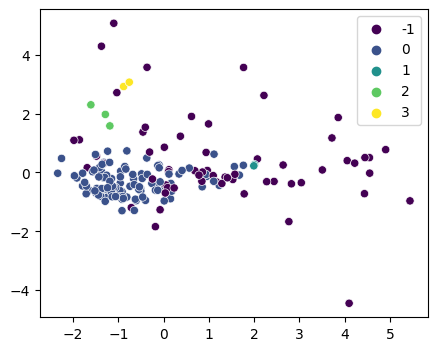

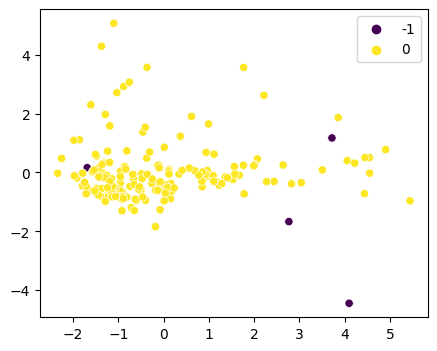

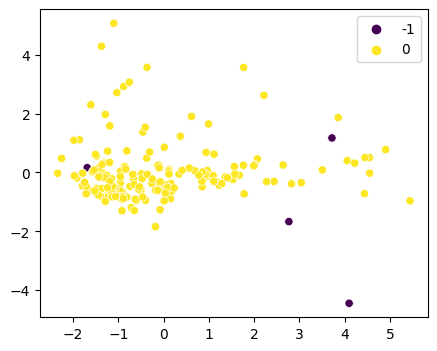

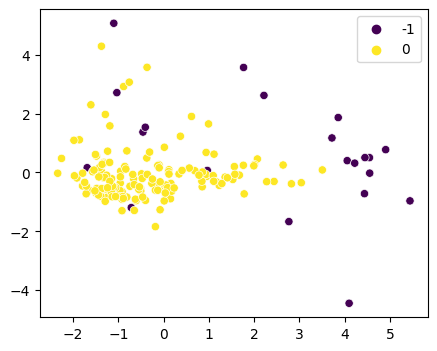

In [ ]:
#Get four best clusterings based on silhoette score. 
for ind in range(4):
    min_samples, eps, score = sorted(output, key=lambda x:x[-ind])[-ind]
    print(f"Best silhouette_score: {score}")
    print(f"min_samples: {min_samples}")
    print(f"eps: {eps}")
    labels = DBSCAN(min_samples=min_samples, eps = eps).fit(x_pca).labels_
    #select plot size and plot the first two PCA components with labels.
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1], hue=labels, palette='viridis');


In this plot, DBSCAN has been used on the PCA data and first two components have been plotted. It is evident, that good clustering hasn't been achieved, even though the silhuette score was relatiely high. One of DBSCANs advantages is that the number of clusters doesn't have to be specified and the algorithm finds them itself. However, in overlapping data, the algorithms performance suffers. 

The data is very clumped together. Hierarcial clustering is perhaps a better choice. Let's see how it is able to perform. 

In [16]:
#hierarchical clustering
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering


In [17]:
#Calculate the silhoette coefficients. 
silhouette_coff = []
for n_clusters in range(2, 11):
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    cluster_labels = clusterer.fit_predict(geneScaled)
    silhouette_coff.append(silhouette_score(geneScaled, cluster_labels))
    print("n_clusters = {}, Silhouette score = {:.3f}".format(n_clusters, silhouette_score(geneScaled, cluster_labels)))

n_clusters = 2, Silhouette score = 0.265
n_clusters = 3, Silhouette score = 0.280
n_clusters = 4, Silhouette score = 0.253
n_clusters = 5, Silhouette score = 0.262
n_clusters = 6, Silhouette score = 0.273
n_clusters = 7, Silhouette score = 0.265
n_clusters = 8, Silhouette score = 0.276
n_clusters = 9, Silhouette score = 0.182
n_clusters = 10, Silhouette score = 0.189


Hierachical clustering provides the worst silhoette scores out of the three algorithms. However, it supports the idea that three clusters is the best choice. 

When conculting experts of the field with superior knowlege to that of ours, agglomerative clustering was suggested as the most likely alternative to give good clustering. Hence, that will be used to make the final labeling of the samples.

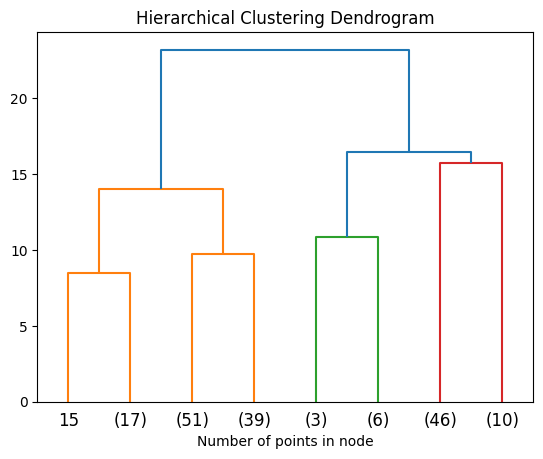

In [ ]:
#this is just for plotting purpouses


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)




# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(geneScaled)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=2)
plt.xlabel("Number of points in node")
plt.show()

In parenthesis are number of samples in the node. Number 15 is sample index.

Kmeans suggested that three clusters provide the best results. Here we can see the algorithm finding four distinct clusters, with two of them being more similiar to each others. The silhoette score for agglomerative clustering also supports the idea of three clusters. Therefore, let us save the clustering results and assign the classes shown below to the TCGA dataframe. 

In [18]:
#perform agglomerative Clustering and save the results as array to luokka-variable.
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
luokka=cluster.fit_predict(geneScaled)
print(luokka)


[2 0 1 1 1 0 2 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 2 0 1 1
 1 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 2 0 1 1 1 1 1 0 1 1 1 1 1
 0 0 1 1 1 1 2 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 2 0 1 1 0 2
 1 1 0 1 0 1 0 2 0 1 1 1 0 1 1 1 1 1 0 1 2 1 1 1 1]


Identified clusters are quite different in size, seems that cluster 2 is relatively small group. 

In [19]:
#scaling might hinder our ability to see differences between clusters
#for now, both scaled and unscaled dataframes are used.
dfGenes=pd.DataFrame(data=geneScaled, index=None, columns = listOfGenes)
dfskaalamaton=pd.DataFrame(data=genes, index=None, columns = listOfGenes)

In [20]:
#adding the results from AG-clustering
dfskaalamaton['labels']= luokka
dfGenes['labels']= luokka



In [21]:
#splitting the dataframes with the cluster
dfGenes1=dfGenes[dfGenes['labels'] == 1]
dfGenes2=dfGenes[dfGenes['labels'] == 0]
dfGenes3=dfGenes[dfGenes['labels'] == 2]
dfskaalamaton1=dfskaalamaton[dfskaalamaton['labels'] == 1]
dfskaalamaton2=dfskaalamaton[dfskaalamaton['labels'] == 0]
dfskaalamaton3=dfskaalamaton[dfskaalamaton['labels'] == 2]




Now, as the data is split, let's plot all the results in an orderly fashion. In the first row: boxplots of each cluster with scaled data. In the second row: the unscaled data, which shows the difference in gene expression more pronouncedly.

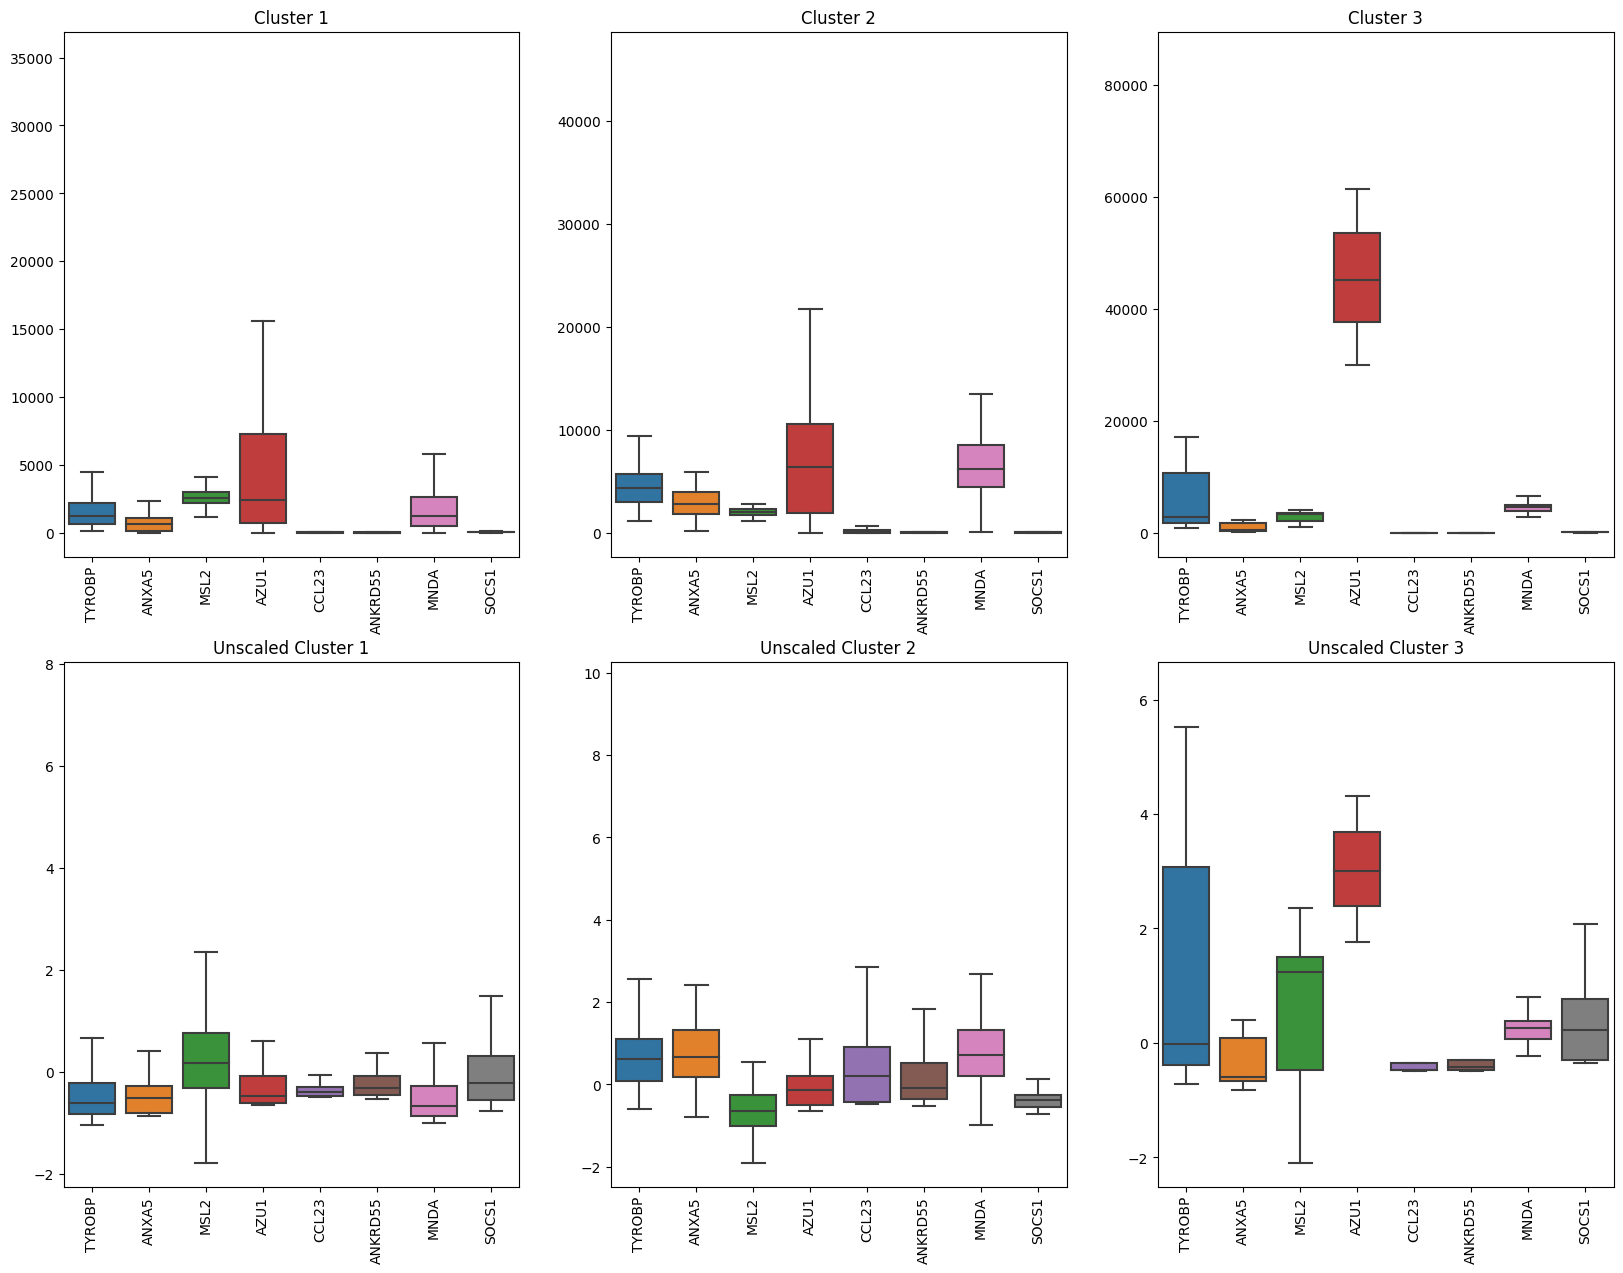

In [ ]:
#plotting all the clusters in scaled, and unscaled sets.
fig, axs = plt.subplots(2,3, figsize=(20, 15), sharey=False)
ax1=sns.boxplot(data=dfskaalamaton1.iloc[:,:-1], fliersize=0, ax=axs[0,0])
ax2=sns.boxplot(data=dfskaalamaton2.iloc[:,:-1], fliersize=0, ax=axs[0,1])
ax3=sns.boxplot(data=dfskaalamaton3.iloc[:,:-1], fliersize=0, ax=axs[0,2])
ax4=sns.boxplot(data=dfGenes1.iloc[:,:-1], fliersize=0, ax=axs[1,0])
ax5=sns.boxplot(data=dfGenes2.iloc[:,:-1], fliersize=0, ax=axs[1,1])
ax6=sns.boxplot(data=dfGenes3.iloc[:,:-1], fliersize=0, ax=axs[1,2])

#set titles
ax1.title.set_text('Cluster 1')
ax2.title.set_text('Cluster 2')
ax3.title.set_text('Cluster 3')
ax4.title.set_text('Unscaled Cluster 1')
ax5.title.set_text('Unscaled Cluster 2')
ax6.title.set_text('Unscaled Cluster 3')
#rotate 90 degrees, so that names can be read
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90) ;
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90) ;
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90) ;
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=90) ;
ax5.set_xticklabels(ax5.get_xticklabels(),rotation=90) ;
ax6.set_xticklabels(ax6.get_xticklabels(),rotation=90) ;


This plot shows both scaled (up) and unscaled (bottom) gene expression values for identified biomarker genes, since differences can often be seen more clearly from unscaled data. There is a clear difference between some of the genes, even though the clustering was somewhat arbitary. 

We can clearly see that some genes are expressed differently between clusters. Especially, cluster 3 seems to be quite different compared to other clusters.  A statistical analysis tool, such as ANOVA could be used to more precisely observe the differences. However, it will not be shown here, as it would require packages that are not supported in Deepnote.

### 6.2 Compare gene expression trends betwen patient subgroups and sensitive/resistant cancer cell lines <a id="section_6.2"></a>



Let us start by building a boxplot for the selected genes in both sensitive and resistant subgroups. First a new dataframe has to be maid, containing only the selected genes.

In [22]:
#Make a new dataframe with only eight genes. Add the target variable for splitting
#Remember that XER was used in pca, and contain ccle data with no missing values. 
XER=pd.DataFrame(data=XER, index=None, columns=ccle.iloc[:, :-2].columns)
CellLineGene=XER[CCLE_gene_names].copy()
CellLineGene.columns = listOfGenes


In [24]:
#for some reason adding the targets doesn't work any other way.
xer1=ccle['target_discrete']
xer1 = xer1.reset_index()
xer1 = xer1.iloc[: , 1:]


In [25]:
CellLineGene = pd.concat([CellLineGene, xer1['target_discrete']], axis = 1)


In [26]:
CellLineGene.head()

TYROBP     ANXA5      MSL2      AZU1     CCL23   ANKRD55      MNDA  \
0 -0.377956 -0.377956 -0.480236 -0.274441 -0.196488 -0.297360 -0.362903   
1 -0.185547 -0.185547 -1.123200 -0.165640  0.077196  0.145684 -0.009610   
2 -0.075423 -0.075423  1.045607 -0.198092 -0.216294 -0.444148 -0.242285   
3 -0.392465 -0.392465  2.139625  0.123205 -0.107927 -0.424849 -0.071967   
4 -0.405352 -0.405352 -0.329388 -0.362351 -0.256676 -0.072671  0.111686   

      SOCS1 target_discrete  
0 -0.895342               0  
1  0.697721               0  
2 -1.250778               0  
3  0.165402               1  
4 -0.799529               0

In [27]:
#split the data
dfCell1=CellLineGene[CellLineGene['target_discrete'] == '0'] #resistant
dfCell2=CellLineGene[CellLineGene['target_discrete'] == '1'] #senstive


Let's take a gander at the gene expression in both groups.

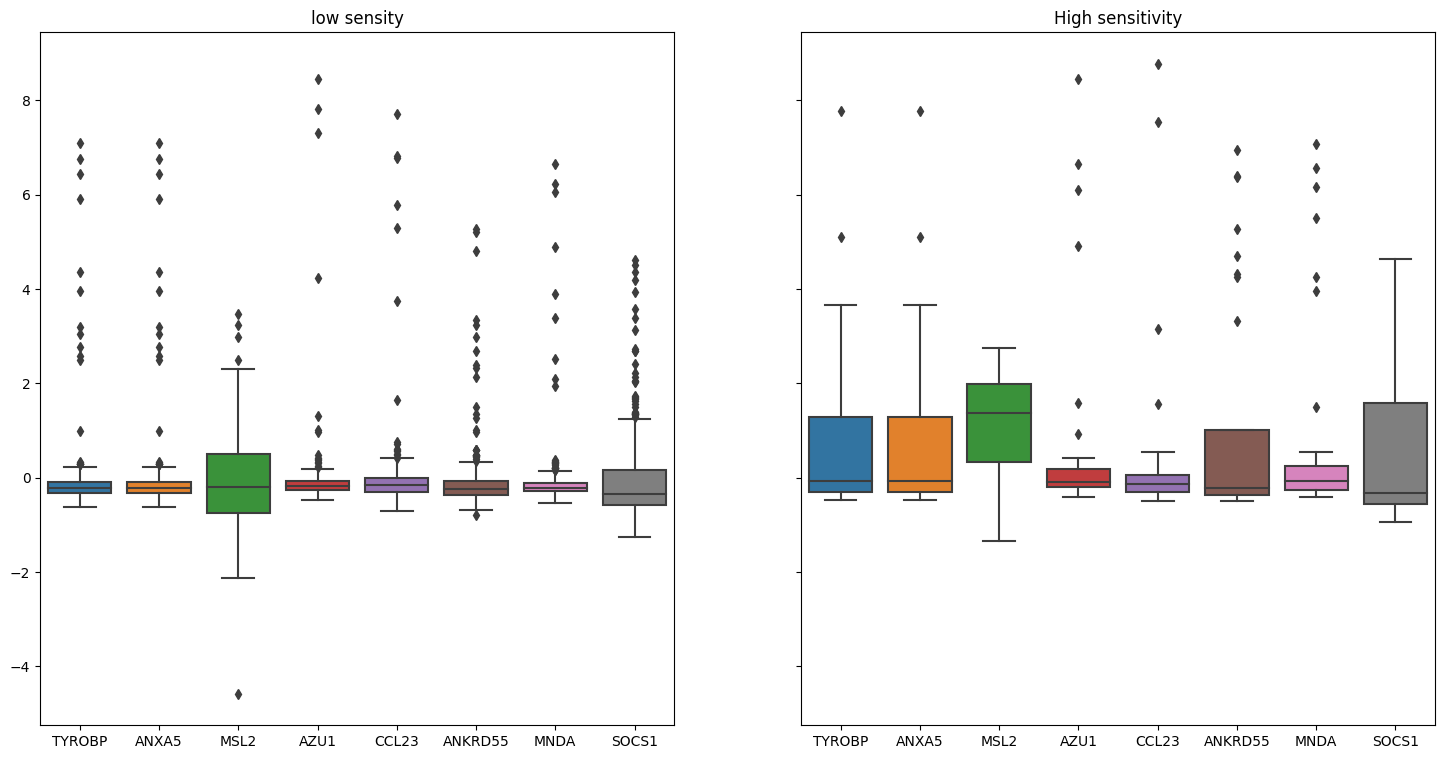

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 9), sharey=True)
ax1=sns.boxplot(data=dfCell1.iloc[:,:-1], ax=axs[0])
ax2=sns.boxplot(data=dfCell2.iloc[:,:-1], ax=axs[1])
ax1.title.set_text('low sensity')
ax2.title.set_text('High sensitivity')

Results of these plots must be interpreted with caution, since we have to consider that group of sensitive cell lines is under represented compared to group of cell lines with low sensitivity, which affects to visualization of the results. Additionally, separation between cell lines with low and high sensitivities was not best possible.  

Looking at the cell lines with low and high sensitivity, we can see a clear difference between the TYROBP gene, which is adaptor protein for tyrosine kinases. As we already know, Nilotinib anti-cancer drug is a kinase-inhibitor. Therefore, it is logical that it is more expressed in sensitive cancer cell lines. High expression of TYROB, also known as DAB12, is associated with good response to chemotherapy (Jia et al. 2022). This is in line with our findings, that shows higher TYROB expression in sensitive cell lines.  Moreover, expression of ANXA5 is higher in sensitive cell line, which also match to observations made in earlier studies. In study conducted by Niu et al., high expression of ANXA5 was associated with better treatment outcome (Niu et al. 2019). Similarly, MSL2 is more expressed in sensitive cell line, which is also consistent with literature. MSL2 is a ligase, which modulates the cytoplasmic expression of well known tumor suppressor p53, linking it to DNA damage responses (Kruse et al. 2009). AZU1 is a tumor suppressor and over expression of AZU1 is linked to sensitivity to chemotherapy, which further supports our findings about that AZU1 is more expressed in sensitive cell lines (Jiang et al. 2020, Wang et at. 2022). MNDA is expressed in myeloid lineage cells and promotes apoptosis under stress conditions, such as chemotherapy. So, it is not surprising that it came up in our analysis. Studies have also linked high expressions of MNDA with better outcome in Chronic lymphatic leukemia, which is consistent with our findings (Bottardi et al. 2020). Based on our results, expression of ANKRD55 is higher in sensitive cell lines as well, but according to literature, protein encoded by this gene rather functions in complex of other proteins and the role of ANKRD55 alone is poorly understood (Ugidos et al. 2019).  

Differences in expression of CCL23 and SOCS1 are not statistically significant. However, visually it seems that higher expression of SOCS1 is seen in sensitive cell lines, but deviation might be so high that differences are not significant. According to literature, SOCS1 is a tumor suppressors and alterations in this gene are linked to Acute myeloid leukemia, which supports our findings that higher expression is detected in sensitive cell lines (Hou et al. 2017). CCL23 instead is a oncogene and associated with poor prognosis for example in Acute lymphatic leukemia (Wang et al. 2022). It could be expected that it is highly expressed in cell lines with low sensitivity to Nilotinib but surprisingly, no differences can be observed. 

In summary, our findings about expression of 8  identified biomarker genes are consistent the literature, when looking at the sensitive cell lines. Several tumor suppressors are expressed in higher levels in sensitive cell lines, as expected. Most of the genes identified in this project were tumor suppressors, only CCL23 is clearly a oncogene, which explains why most of the changes are explainable in sensitive cell lines. 

In [ ]:
#Levene's test
from scipy.stats import levene
variancelistCell=[]
for x in listOfGenes:
    z=levene(dfCell1[x], dfCell2[x], proportiontocut=0)
    variancelistCell.append(levene(dfCell1[x], dfCell2[x], proportiontocut=0))
    print("gene:",x, "p-value:", z[1])


gene: TYROBP p-value: 1.5173740346107234e-06
gene: ANXA5 p-value: 1.5173740346107234e-06
gene: MSL2 p-value: 0.04789212998205693
gene: AZU1 p-value: 3.635924833838441e-06
gene: CCL23 p-value: 0.001582743814500932
gene: ANKRD55 p-value: 3.60887881899385e-12
gene: MNDA p-value: 7.548972494233613e-09
gene: SOCS1 p-value: 0.00034321986409219913


In [ ]:
from scipy import stats
significanceList=[]
for x in listOfGenes:
    z=stats.ttest_ind(dfCell1[x], dfCell2[x], equal_var=False)
    significanceList.append(stats.ttest_ind(dfCell1[x], dfCell2[x], equal_var=False))
    print("gene:",x, "p-value:", z[1])

gene: TYROBP p-value: 0.009289419704596071
gene: ANXA5 p-value: 0.009289419704596071
gene: MSL2 p-value: 4.872879280279311e-06
gene: AZU1 p-value: 0.03695549472791539
gene: CCL23 p-value: 0.13660089361474098
gene: ANKRD55 p-value: 0.009848299633011126
gene: MNDA p-value: 0.01506549537140603
gene: SOCS1 p-value: 0.059016187469050345


Let us compare the sensitive and resistant cell line data to to cancer patient data.

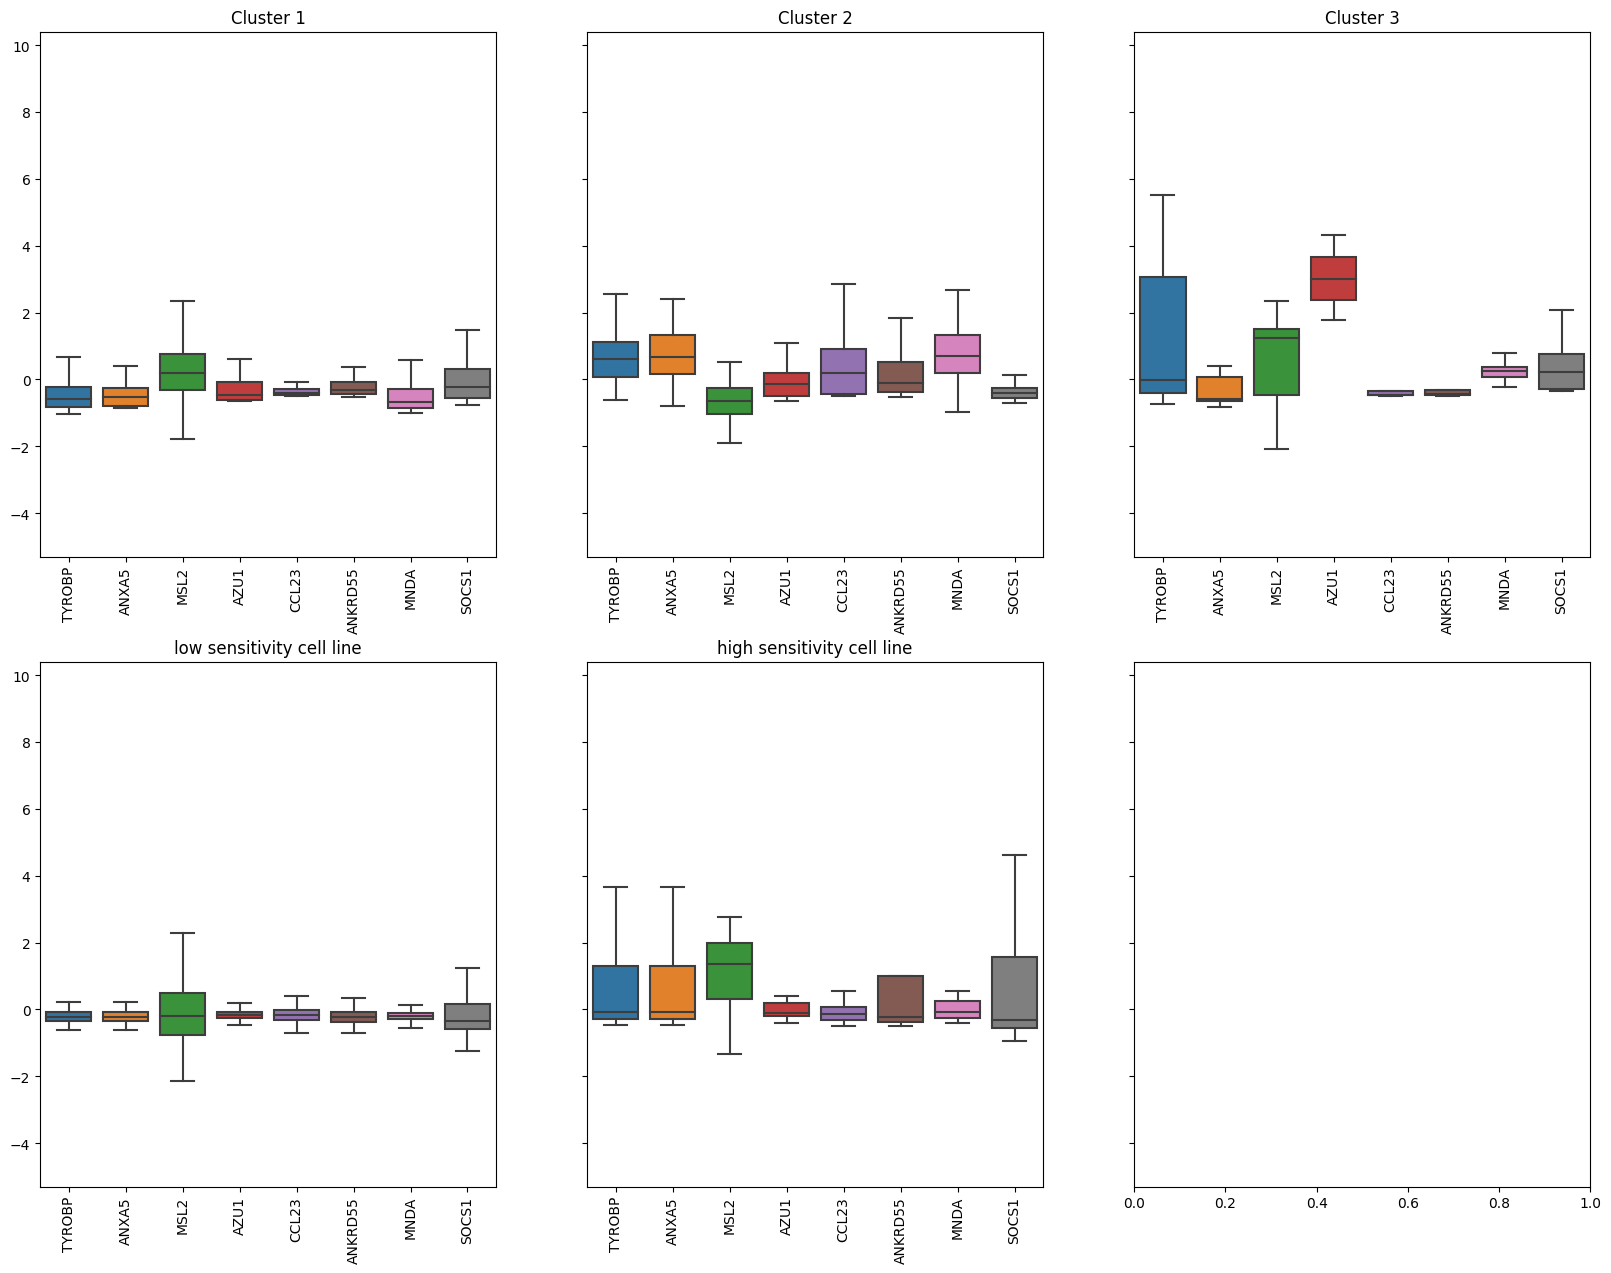

In [28]:
#plotting all the clusters in scaled, and unscaled sets.
fig, axs = plt.subplots(2,3, figsize=(20, 15), sharey=True)

ax1=sns.boxplot(data=dfGenes1.iloc[:,:-1], fliersize=0, ax=axs[0,0])
ax2=sns.boxplot(data=dfGenes2.iloc[:,:-1], fliersize=0, ax=axs[0,1])
ax3=sns.boxplot(data=dfGenes3.iloc[:,:-1], fliersize=0, ax=axs[0,2])
ax4=sns.boxplot(data=dfCell1.iloc[:,:-1], fliersize=0, ax=axs[1,0])
ax5=sns.boxplot(data=dfCell2.iloc[:,:-1], fliersize=0, ax=axs[1,1])
#set titles
ax1.title.set_text('Cluster 1')
ax2.title.set_text('Cluster 2')
ax3.title.set_text('Cluster 3')
ax4.title.set_text('low sensitivity cell line')
ax5.title.set_text('high sensitivity cell line')

#rotate 90 degrees, so that names can be read
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90) ;
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90) ;
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90) ;
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=90) ;
ax5.set_xticklabels(ax5.get_xticklabels(),rotation=90) ;


In this figure, upper row represents biomarker gene expression in different clusters (1-3) identified from patient data, whereas bottom row shows the gene expression in cell lines with low and high sensitivity. 

At first glance, cluster 3 seems very distinct from clusters 1 and 2. High expression of TYROBP, AZU1 and MSL2 is characteristic for cluster 3. The expression of SOCS2 also follows similar expression pattern as sensitive cell line.  All these genes are associated with better treatment outcomes, which allows us to expect that this group of patients could have better therapy responses when comparing to other groups. 

As mentioned, differences between clusters 1 and 2 are not that clear. Expression of these biomarkers, most of which were tumor suppressors and associated with good therapy responses, is very low in cluster 1, which could indicate that this group of patients have a risk for poorer therapy response. When looking at the pattern of expression values, this cluster seems to have similarities with the pattern of cell line with low sensitivity. 

Cluster two seems to fall somewhere in between. Expression of TYROBP and ANXA5 are high and similiar to cluster 3, however MSL2 more resembles that of the resistant gene expression. CCL23, ANKRD55 and MNDA have the highest expression out of the three clusters. SOCS1 also resembles the resistant cluster. Expression of CCL23 was not significantly different among resistant and sensitive cell lines. ANKRD55 is comparable to the cluster 1 which has lower sensitivity.  High MNDA is linked with better outcomes in cancer therapy. Therefore, cluster 2 would most likely get varied, or intermediate results from nilotinib treatment. 

## 7. Discussion <a id="section_7"></a>



In this machine learning project we analyzed the effect of anti-cancer drug, Nilotinib on cancer cell lines. Nilotinib is a tyrosine kinase inhibitor used in treatment of CML (Deininger et al. 2008). Drug treated cancer cell line RNA-seq data was acquired from cancer cell line encyclopedia (CCLE) and Genomics of Drug Sensitivity in Cancer (GDSC). 

In the first part of the project, three different classification algorithms were used to make a predictive model.  Best classification results were achieved with Random Forest (RF), where over 90% accuracy was achieved in training, testing and external validation. This is expected, as RF is generally one of the best performing algorithms, only losing to Deep learning (DL). Furthermore, in a highly structured and relatively small datasets, the benefits of deep learning usually are not achieved (Meyers et al. 2019). Support vector machine (SVM) is generally precise algorithm. However, PCA  revealed that the data is somewhat overlapping, which limits the accuracy of the algorithm. 

Other algorithms used were Naive Bayes and K- Nearest neighbors, neither of which achieved good accuracy. KNN is a simple algorithm to implement and as non-parametric. Therefore, it is a good first choice. Naive Bayes is generally a poor algorithm, but in overlapping and noisy data, its accuracy is less affected than other algorithms (Atla at el. 2011). 

In addition to classification, three different regression algorithms were utilized to predict a numeric estimate for AUC-values for unseen cell lines. A simplest regression algorithm is linear regression. However, collinearity analysis revealed the data of having many correlating genes. Therefore, Lasso and ElasticNet, which utilize regularization methods to deal with collinearity were a more desired choice (Géron 2017). From the results of the regression algorithms, it is clearly seen how both Lasso and ElasticNet drastically outperform linear regression.  Ridge regression wasn't included since RG includes all the features in the regression model even if some of these features are irrelevant. This is to be avoided when there are more features than training instances.

In the second part of the project TCGA data was analyzed to find clusters of leukemia patients and to see, if some subgroups of the patients could be more sensitive to Nilotinib than others. Eight genes were used as biomarkers for sensitivity. These biomarkers were selected by analyzing feature importances in Random Forest, Lasso and ElasticNet algorithms. I.e. selecting the top genes, that the models used to differentiate between low and high sensitivity (or small or large AUC values for) cell lines.

Different clustering algorithms were used, with most models agreeing that 3 clusters is the optimal number. Agglomerative clustering was used to divide the TCGA data into three subgroups. Boxplots created from expression levels of biomarker genes revealed that gene expression between clusters was indeed significantly different.

Clusters were compared to resistant and sensitive clusters from CCLE data. It was seen, that some clusters more resembeled the sensitive or resistant clusters than others. Indeed, out studies find, that pharmagenomic approach to treatment of leukemia, might improve results.  However, further studies needs to be conducted on the matter. Findings made in this project could be confirmed in different datasets. 

## 8. References <a id="section_8"></a>

Goodspeed, A., Heiser, L. M., Gray, J. W., & Costello, J. C. (2016). Tumor-Derived Cell Lines as Molecular Models of Cancer Pharmacogenomics. Molecular cancer research : MCR, 14(1), 3–13.

Kantarjian, H. M., Hughes, T. P., Larson, R. A., Kim, D. W., Issaragrisil, S., le Coutre, P., Etienne, G., Boquimpani, C., Pasquini, R., Clark, R. E., Dubruille, V., Flinn, I. W., Kyrcz-Krzemien, S., Medras, E., Zanichelli, M., Bendit, I., Cacciatore, S., Titorenko, K., Aimone, P., Saglio, G., … Hochhaus, A. (2021). Long-term outcomes with frontline nilotinib versus imatinib in newly diagnosed chronic myeloid leukemia in chronic phase: ENESTnd 10-year analysis. Leukemia, 35(2), 440–453. 

Barretina, J., Caponigro, G., Stransky, N., Venkatesan, K., Margolin, A. A., Kim, S., Wilson, C. J., Lehár, J., Kryukov, G. V., Sonkin, D., Reddy, A., Liu, M., Murray, L., Berger, M. F., Monahan, J. E., Morais, P., Meltzer, J., Korejwa, A., Jané-Valbuena, J., Mapa, F. A., … Garraway, L. A. (2012). The Cancer Cell Line Encyclopedia enables predictive modelling of anticancer drug sensitivity. Nature, 483(7391), 603–607. 

Yang, W., Soares, J., Greninger, P., Edelman, E. J., Lightfoot, H., Forbes, S., Bindal, N., Beare, D., Smith, J. A., Thompson, I. R., Ramaswamy, S., Futreal, P. A., Haber, D. A., Stratton, M. R., Benes, C., McDermott, U., & Garnett, M. J. (2013). Genomics of Drug Sensitivity in Cancer (GDSC): a resource for therapeutic biomarker discovery in cancer cells. Nucleic acids research, 41(Database issue), D955–D961.

Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow : concepts, tools, and techniques to build intelligent systems. Sebastopol, CA: O'Reilly Media. ISBN: 978-1491962299

Wang, J., Zhuo, Z., Wang, Y., Yang, S., Chen, J., Wang, Y., Geng, S., Li, M., Du, X., Lai, P., & Weng, J. (2022). Identification and Validation of a Prognostic Risk-Scoring Model Based on Ferroptosis-Associated Cluster in Acute Myeloid Leukemia. Frontiers in cell and developmental biology, 9, 800267. https://doi.org/10.3389/fcell.2021.800267

Ugidos, N., Mena, J., Baquero, S., Alloza, I., Azkargorta, M., Elortza, F., & Vandenbroeck, K. (2019). Interactome of the Autoimmune Risk Protein ANKRD55. Frontiers in immunology, 10, 2067. https://doi.org/10.3389/fimmu.2019.02067

Bottardi, S., Guieze, R., Bourgoin, V., Fotouhi-Ardakani, N., Dougé, A., Darracq, A., Lakehal, Y. A., Berger, M. G., Mollica, L., Bay, J. O., Omichinski, J. G., & Milot, E. (2020). MNDA controls the expression of MCL-1 and BCL-2 in chronic lymphocytic leukemia cells. Experimental hematology, 88, 68–82.e5. https://doi.org/10.1016/j.exphem.2020.07.004

Hou, H. A., Lu, J. W., Lin, T. Y., Tsai, C. H., Chou, W. C., Lin, C. C., Kuo, Y. Y., Liu, C. Y., Tseng, M. H., Chiang, Y. C., Peng, Y. L., Tang, J. L., Gong, Z., Lin, L. I., & Tien, H. F. (2017). Clinico-biological significance of suppressor of cytokine signaling 1 expression in acute myeloid leukemia. Blood cancer journal, 7(7), e588. https://doi.org/10.1038/bcj.2017.67

Zhang, X., Liu, S., Guo, C., Zong, J., & Sun, M. Z. (2012). The association of annexin A2 and cancers. Clinical and Translational Oncology, 14(9), 634-640.

Jia, R., Ji, M., Li, G., Xia, Y., Guo, S., Li, P., Sun, Y., Lu, F., Zhang, J., Zang, S., Yan, S., Ye, J., Xue, F., Ma, D., Sun, T., & Ji, C. (2022). Subclones of bone marrow CD34+ cells in acute myeloid leukemia at diagnosis confer responses of patients to induction chemotherapy. Cancer, 128(22), 3929–3942.

Niu, Y., Yang, X., Chen, Y., Jin, X., Xie, Y., Tang, Y., Li, L., Liu, S., Guo, Y., Li, X., Duan, L., & Wang, H. (2019). Distinct prognostic values of Annexin family members expression in acute myeloid leukemia. Clinical & translational oncology : official publication of the Federation of Spanish Oncology Societies and of the National Cancer Institute of Mexico, 21(9), 1186–1196. 

Liao, W., Jordaan, G., Nham, P. et al. Gene expression and splicing alterations analyzed by high throughput RNA sequencing of chronic lymphocytic leukemia specimens. BMC Cancer 15, 714 (2015). https://doi.org/10.1186/s12885-015-1708-9

Jiang, L., Li, X. P., Dai, Y. T., Chen, B., Weng, X. Q., Xiong, S. M., ... & Chen, S. J. (2020). Multidimensional study of the heterogeneity of leukemia cells in t (8; 21) acute myelogenous leukemia identifies the subtype with poor outcome. Proceedings of the National Academy of Sciences, 117(33), 20117-20126.

Kruse, J. P., & Gu, W. (2009). MSL2 promotes Mdm2-independent cytoplasmic localization of p53. Journal of Biological Chemistry, 284(5), 3250-3263.

Deininger, M. W. (2008). Nilotinib. Clinical Cancer Research, 14(13), 4027-4031.

Atla, A., Tada, R., Sheng, V., & Singireddy, N. (2011). Sensitivity of different machine learning algorithms to noise. Journal of Computing Sciences in Colleges, 26(5), 96-103.

Meyer, J. G., Liu, S., Miller, I. J., Coon, J. J., & Gitter, A. (2019). Learning drug functions from chemical structures with convolutional neural networks and random forests. Journal of chemical information and modeling, 59(10), 4438-4449.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=218917ea-7aa7-4d0f-a908-91e26897f73b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>